# Validate Motion State

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import fetch_data
import numpy as np
import correct_drift
import datetime
from scipy import signal
from scipy.spatial.transform import Rotation as R
from ahrs.filters import Madgwick
from ahrs.filters import Mahony

import importlib
importlib.reload(fetch_data)

<module 'fetch_data' from '/home/tyler/Documents/Matt3r/IMU_validation/fetch_data.py'>

Select Data

In [16]:
# Hamid data
start_date_str = '2023-06-28'
end_date_str = '2023-06-28'
organization_id = 'hamid'
can_k3y_id = '17700cf8'
imu_k3y_id = '17700cf8'

In [19]:
# Amir M data
start_date_str = '2023-06-28'
end_date_str = '2023-06-28'
organization_id = 'amirm'
can_k3y_id = 'c9a6b512'
imu_k3y_id = 'c9a6b512'

Get the CAN Server Data

In [6]:
event_dict = fetch_data.get_events(can_k3y_id, organization_id, start_date_str, end_date_str)
can_df = fetch_data.get_can_data(can_k3y_id, organization_id, start_date_str, end_date_str)

Get the IMU Data

In [20]:
# use if we have clock data
imu_df = fetch_data.get_imu_data(imu_k3y_id, organization_id, start_date_str, end_date_str)

Correct the Rotation Matrix for Hamid's Data

In [19]:
GLOVE_TO_CONSOLE_MTX = np.array([[0, 0, 1], [0.0856, 0.9963, 0], [-0.9963, 0.0856, 0]])
S3_K3Y_VEH_ROT_MTX_CONSOLE = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
S3_K3Y_VEH_ROT_MTX = np.matmul(S3_K3Y_VEH_ROT_MTX_CONSOLE, GLOVE_TO_CONSOLE_MTX)
CORRECTION_MATRIX = S3_K3Y_VEH_ROT_MTX_CONSOLE@np.linalg.inv(S3_K3Y_VEH_ROT_MTX)

# az = 9.83
# # ay = 0.835
# ay = 0.987
# g = np.sqrt(az**2 + ay**2)
# TILT_ROT = np.array([[1, 0, 0], [0, az/g, -ay/g], [0, ay/g, az/g]])

# CORRECTION_MATRIX = S3_K3Y_VEH_ROT_MTX_CONSOLE@TILT_ROT@np.linalg.inv(S3_K3Y_VEH_ROT_MTX)

if organization_id == 'hamid':
    acc_np = imu_df[['correct_timestamp', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)']].to_numpy()
    vehicle_ac = np.matmul(CORRECTION_MATRIX, acc_np[:, 1:].T)
    vehicle_ac_np = np.column_stack((acc_np[:,0], vehicle_ac.T))
    imu_df = pd.DataFrame(vehicle_ac_np, columns=['correct_timestamp', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)'])

Use the speed data to create stationary and driving states

In [36]:
speed_df = can_df[can_df['speed'].notna()]
speed_df.reset_index(drop=True, inplace=True)
test = speed_df[speed_df['speed'] < 1]['timestamp']
pd.set_option('display.max_rows', None)
test.diff()

0               NaN
1          1.440000
2          0.060000
3          0.140000
4          0.220000
5          0.060000
6          0.120000
7          0.041000
8          0.139000
9          0.600000
10         0.060000
11         0.040000
12         0.200000
13         0.120000
14         0.320000
15         0.100000
16         0.620000
17         0.460000
18         0.340000
24         1.700000
25         0.360000
26         0.121000
27         0.619000
28         0.060000
29         0.180000
30         0.441000
31         0.100000
32         0.039000
33         0.041000
34         0.378000
35         0.321000
36         0.101000
37         0.259000
38         0.400000
39         0.662000
40         0.599000
41         0.038000
42         0.042000
43         0.379000
44         0.080000
45         1.000000
46         0.839000
47         0.223000
48         0.176000
49         0.061000
50         0.020000
51         0.640000
52         0.340000
53         0.400000
54         0.101000


Filter Out Warmup Time

In [6]:
warmup_start = 1687886372
warmup_end = 1687886435
imu_df = imu_df[(imu_df['correct_timestamp'] <= warmup_start) | (imu_df['correct_timestamp'] >= warmup_end)]

Get Stationary State Data Metrics

In [21]:
# stitching together all stationary state data
imu_ss_states = []
can_ss_states = []
for state_num in range(len(event_dict['stationary_state'])):
    ss_start_time = event_dict['stationary_state'][state_num]['start']
    ss_end_time = event_dict['stationary_state'][state_num]['end']
    imu_ss_states.append(imu_df[(imu_df['correct_timestamp'] >= ss_start_time) 
                       & (imu_df['correct_timestamp'] <= ss_end_time)])
    can_ss_states.append(can_df[(can_df['timestamp'] >= ss_start_time) 
                        & (can_df['timestamp'] <= ss_end_time)])
imu_ss_df = pd.concat(imu_ss_states, ignore_index=True)
can_ss_df = pd.concat(can_ss_states, ignore_index=True)

print('left/right acceleration:')
print(f'imu mean: {imu_ss_df["lr_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["lr_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["lr_acc(m/s^2)"].min()}')
print(f'can mean: {can_ss_df["lr_acc"].mean()}')
print(f'can max: {can_ss_df["lr_acc"].max()}')
print(f'can min: {can_ss_df["lr_acc"].min()}')
print('')
print('back/from acceleration:')
print(f'imu mean: {imu_ss_df["bf_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["bf_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["bf_acc(m/s^2)"].min()}')
print(f'can mean: {can_ss_df["bf_acc"].mean()}')
print(f'can max: {can_ss_df["bf_acc"].max()}')
print(f'can min: {can_ss_df["bf_acc"].min()}')
print('')
print('vertical acceleration:')
print(f'imu mean: {imu_ss_df["vert_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["vert_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["vert_acc(m/s^2)"].min()}')
print(f'can mean: {can_ss_df["vert_acc"].mean()}')
print(f'can max: {can_ss_df["vert_acc"].max()}')
print(f'can min: {can_ss_df["vert_acc"].min()}')
print('')
print('normalized acceleration:')
imu_norm = np.sqrt(imu_ss_df['lr_acc(m/s^2)']**2 + imu_ss_df['bf_acc(m/s^2)']**2 + imu_ss_df['vert_acc(m/s^2)']**2)
can_norm = np.sqrt(can_ss_df['lr_acc']**2 + can_ss_df['bf_acc']**2 + can_ss_df['vert_acc']**2)
print(f'imu mean: {imu_norm.mean()}')
print(f'imu max: {imu_norm.max()}')
print(f'imu min: {imu_norm.min()}')
print(f'can mean: {can_norm.mean()}')
print(f'can max: {can_norm.max()}')
print(f'can min: {can_norm.min()}')

left/right acceleration:
imu mean: 0.08917500723024413
imu max: 5.380598122680231
imu min: -4.0082614169451976
can mean: -0.1612839079453973
can max: 0.68
can min: -0.895

back/from acceleration:
imu mean: -0.029501381472975804
imu max: 2.7919753466790147
imu min: -2.68933746519392
can mean: -0.009986788741610991
can max: 0.65
can min: -1.0775000000000001

vertical acceleration:
imu mean: 0.01286271255675707
imu max: 4.799681023688012
imu min: -3.829702138018781
can mean: -0.034769777891068464
can max: 0.0625
can min: -0.16375

normalized acceleration:
imu mean: 0.3079251454953892
imu max: 6.393896367668647
imu min: 0.0016509731016713962
can mean: 0.2733394031277177
can max: 1.1251833183974955
can min: 0.08881159834165805


In [23]:
# driving state metrics

dr_df = imu_df
for state_num in range(len(event_dict['stationary_state'])):
    ss_start_time = event_dict['stationary_state'][state_num]['start']
    ss_end_time = event_dict['stationary_state'][state_num]['end']
    dr_df = dr_df[(dr_df['correct_timestamp'] <= ss_start_time) | (dr_df['correct_timestamp'] >= ss_end_time)]

print('left/right acceleration:')
print(f'imu mean: {dr_df["lr_acc(m/s^2)"].mean()}')
print(f'imu max: {dr_df["lr_acc(m/s^2)"].max()}')
print(f'imu min: {dr_df["lr_acc(m/s^2)"].min()}')
print('')
print('back/from acceleration:')
print(f'imu mean: {dr_df["bf_acc(m/s^2)"].mean()}')
print(f'imu max: {dr_df["bf_acc(m/s^2)"].max()}')
print(f'imu min: {dr_df["bf_acc(m/s^2)"].min()}')
print('')
print('vertical acceleration:')
print(f'imu mean: {dr_df["vert_acc(m/s^2)"].mean()}')
print(f'imu max: {dr_df["vert_acc(m/s^2)"].max()}')
print(f'imu min: {dr_df["vert_acc(m/s^2)"].min()}')
print('')
print('normalized acceleration:')
imu_norm = np.sqrt(dr_df['lr_acc(m/s^2)']**2 + dr_df['bf_acc(m/s^2)']**2 + dr_df['vert_acc(m/s^2)']**2)
print(f'imu mean: {imu_norm.mean()}')
print(f'imu max: {imu_norm.max()}')
print(f'imu min: {imu_norm.min()}')

left/right acceleration:
imu mean: 0.04401516667602057
imu max: 4.3074497715528315
imu min: -5.11589307558144

back/from acceleration:
imu mean: -0.029117000444547483
imu max: 4.3984087122587
imu min: -3.7922467207464647

vertical acceleration:
imu mean: 0.02569670257407824
imu max: 6.278671958647768
imu min: -5.474511790405966

normalized acceleration:
imu mean: 0.09414656288417161
imu max: 6.607513983231151
imu min: 0.0015054072859146475


Filter Only Driving States

22
1687985497.7885432
1687985765.011826
1687985765.0247567
267.2232828140259


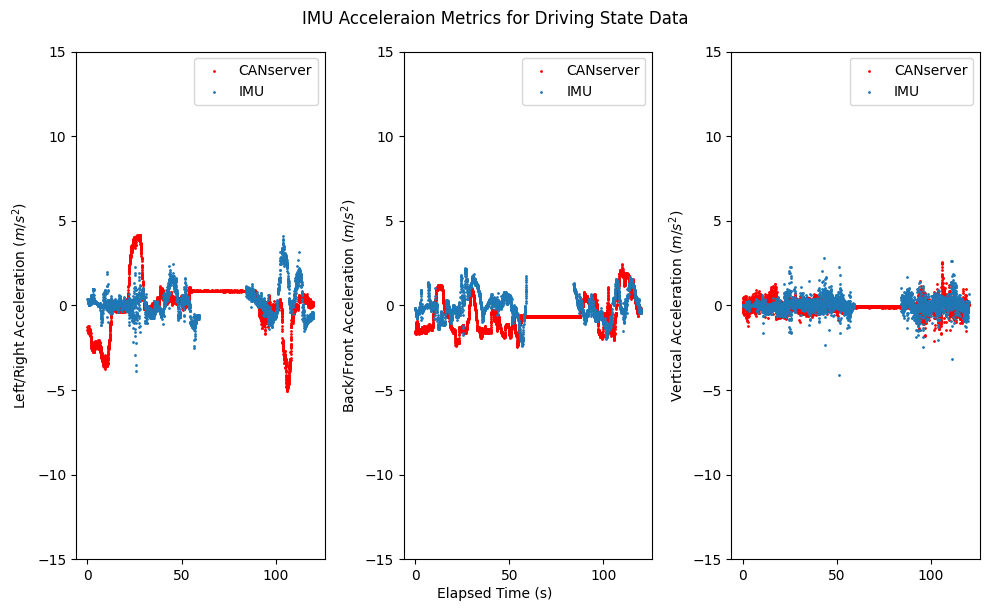

23
1687985617.5790713
1687985885.025392
1687985885.0287125
267.446320772171


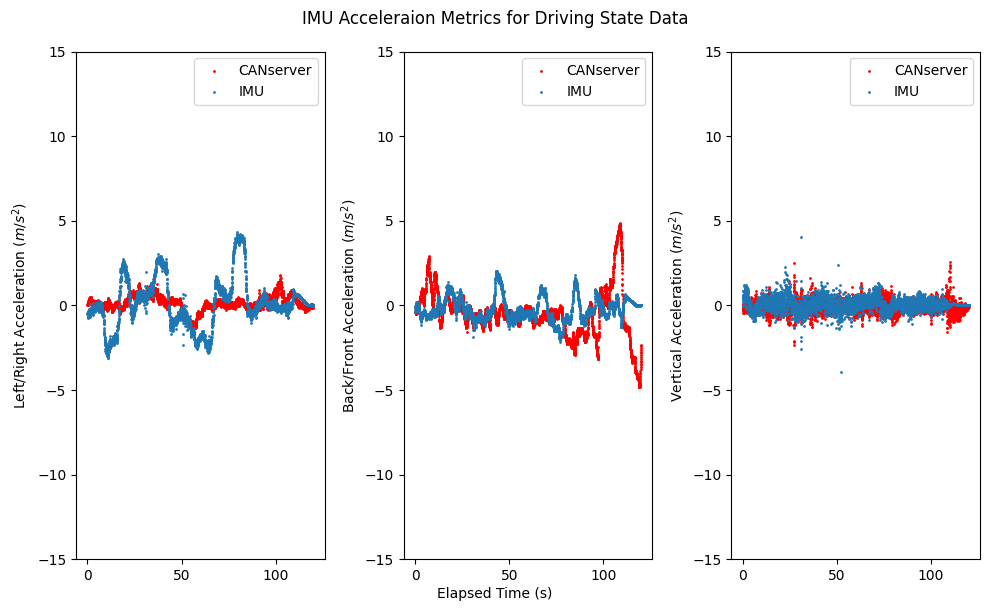

24
1687985737.369599
1687986005.017878
1687986005.032668
267.6482789516449


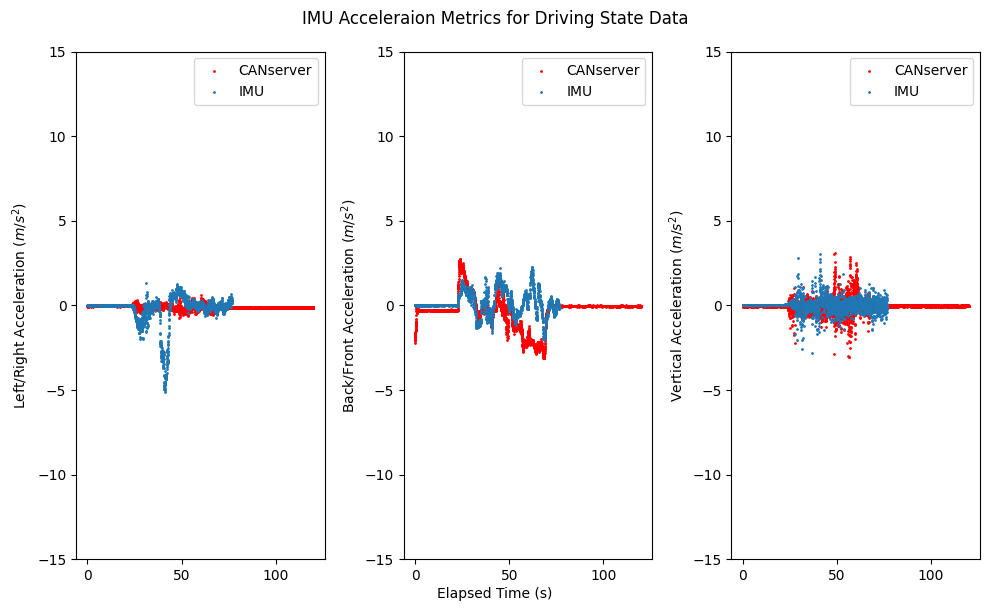

25
1687985874.986298
1687986125.013188
1687986142.894555
250.0268898010254


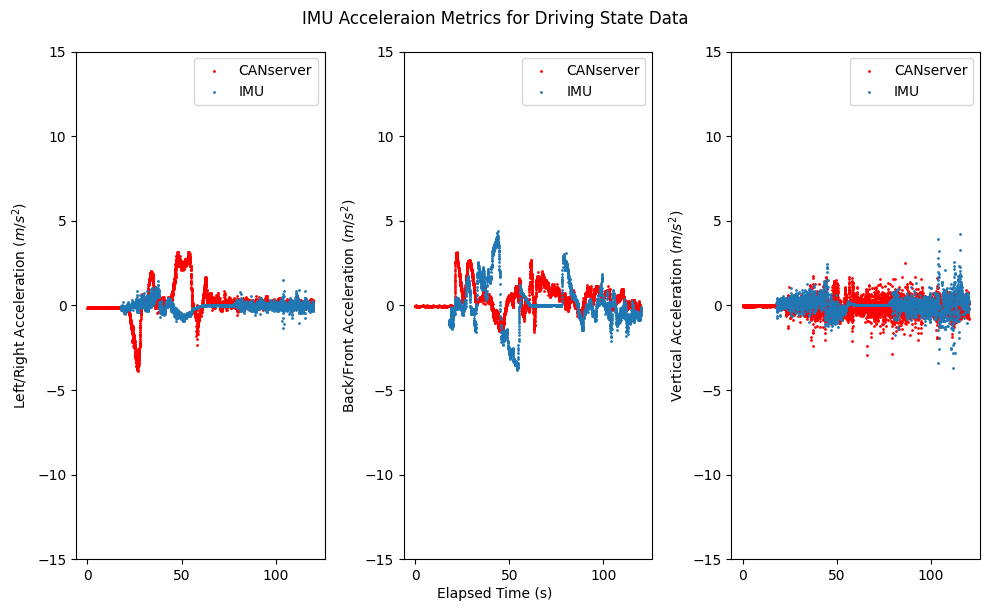

26
1687985976.9506552
1687986245.023462
1687986245.0405796
268.07280683517456


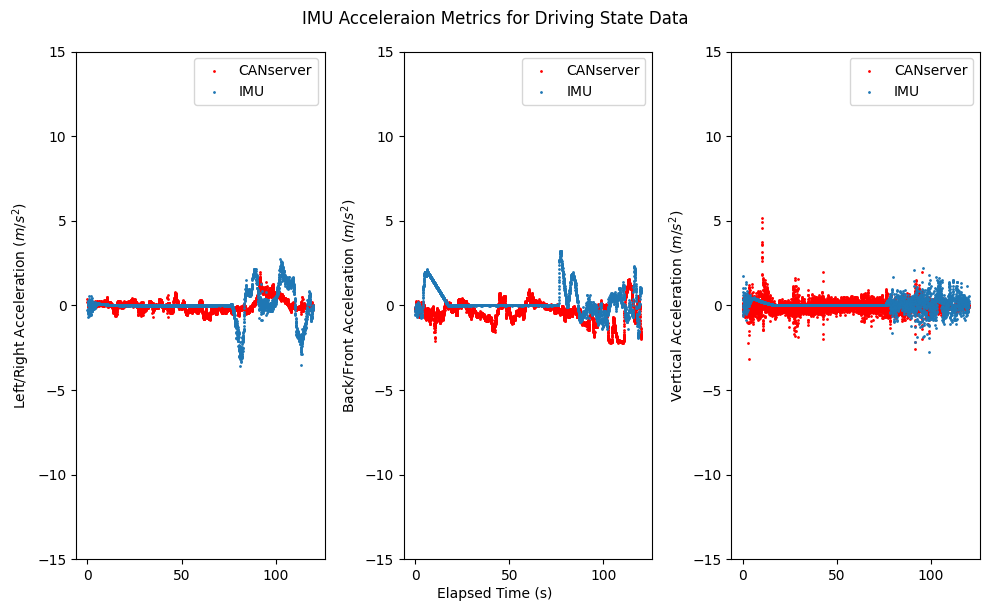

27
1687986096.7411833
1687986365.017817
1687986365.0445354
268.27663373947144


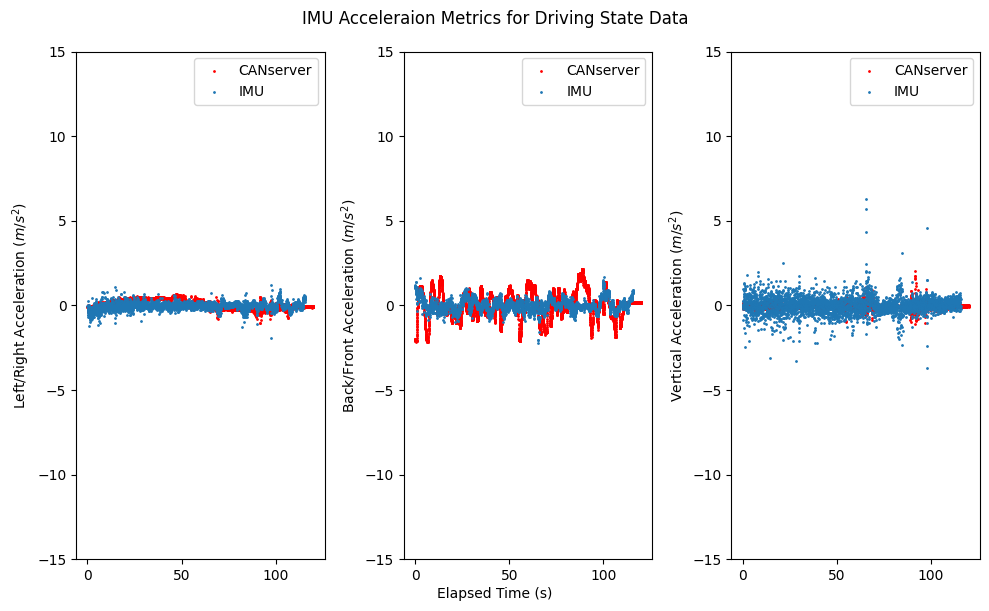

28
1687986222.2615519
1687986485.013132
1687986490.7885404
262.7515802383423


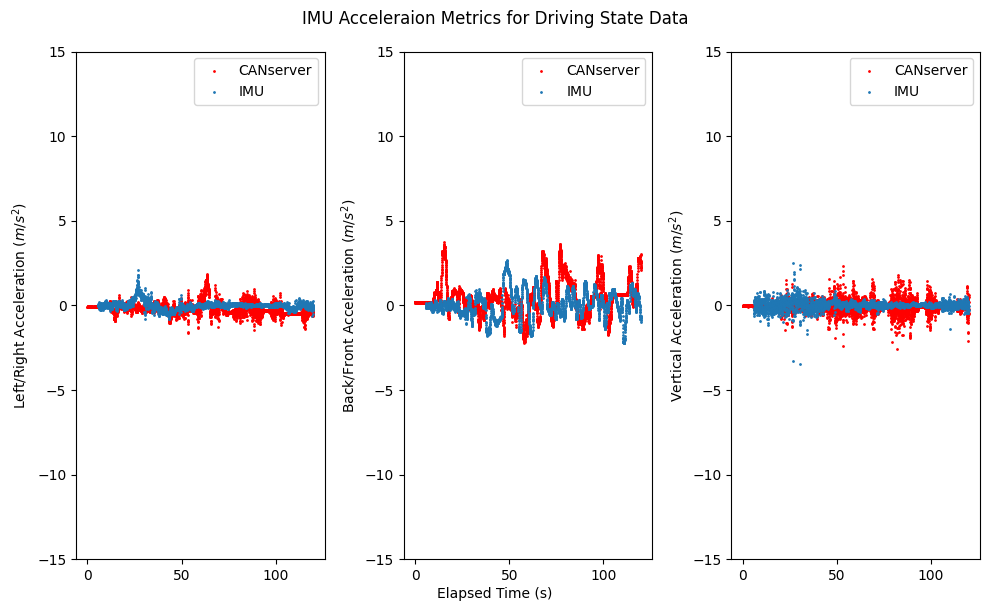

29
1687986336.288731
1687986605.026478
1687986605.018879
268.73774695396423


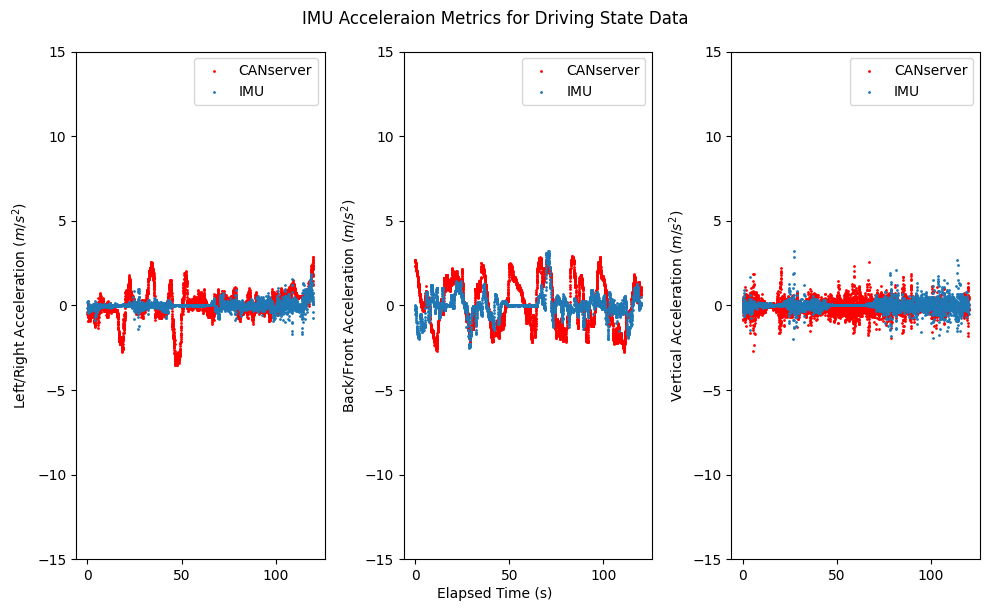

30
1687986456.0792592
1687986725.018755
1687986725.0228345
268.93949580192566


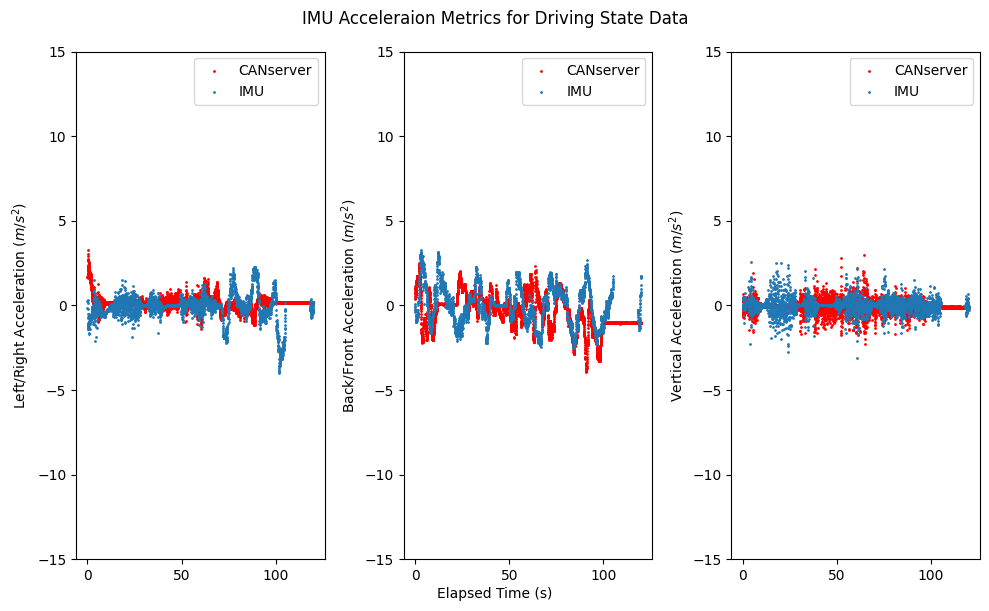

31
1687986575.8697875
1687986845.013592
1687986845.0267906
269.1438045501709


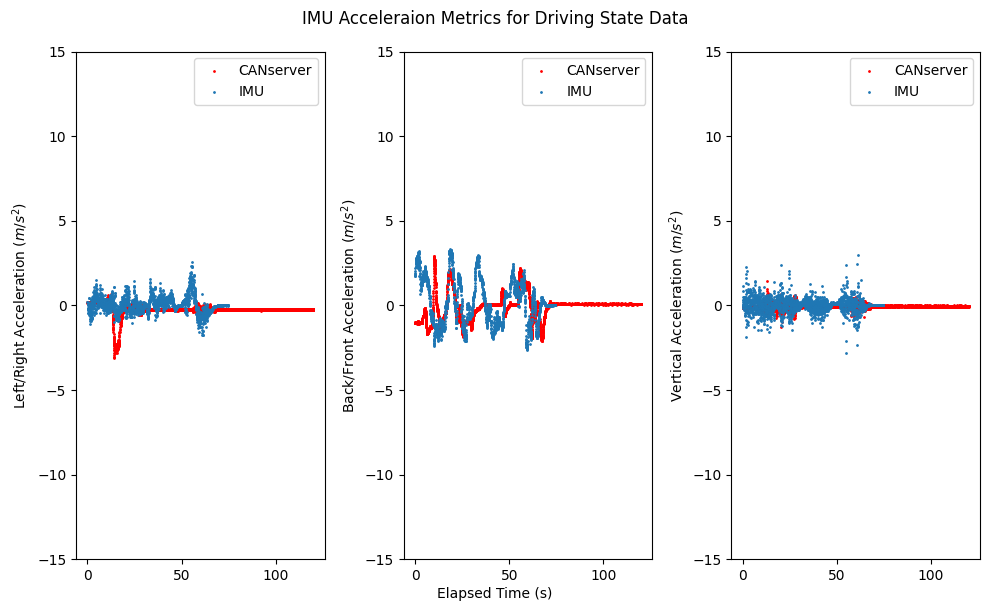

32
1687986701.5912027
1687986965.026312
1687986970.9722004
263.43510937690735


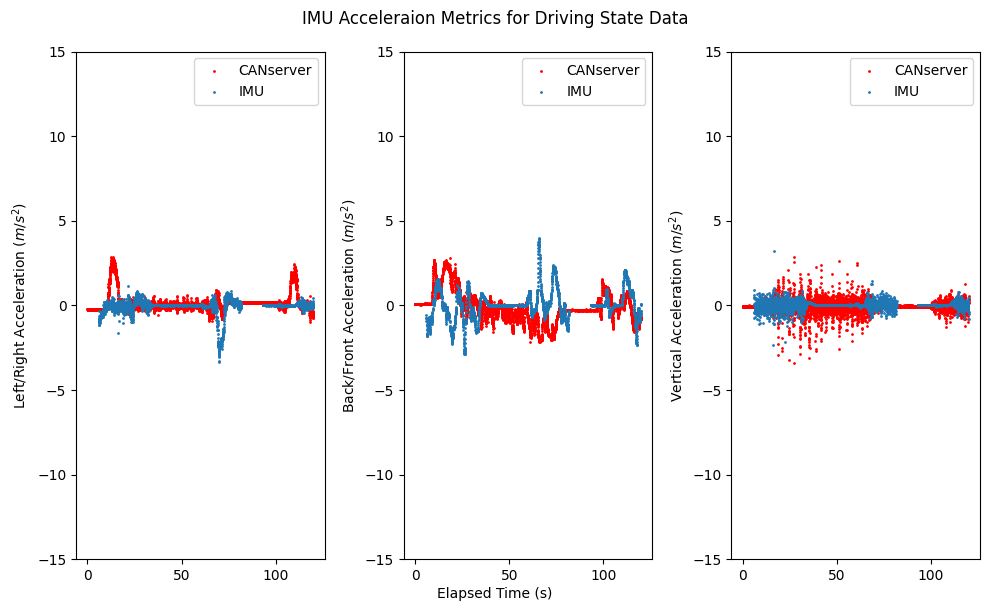

33
1687986815.450843
1687987085.021549
1687987085.0347016
269.5707058906555


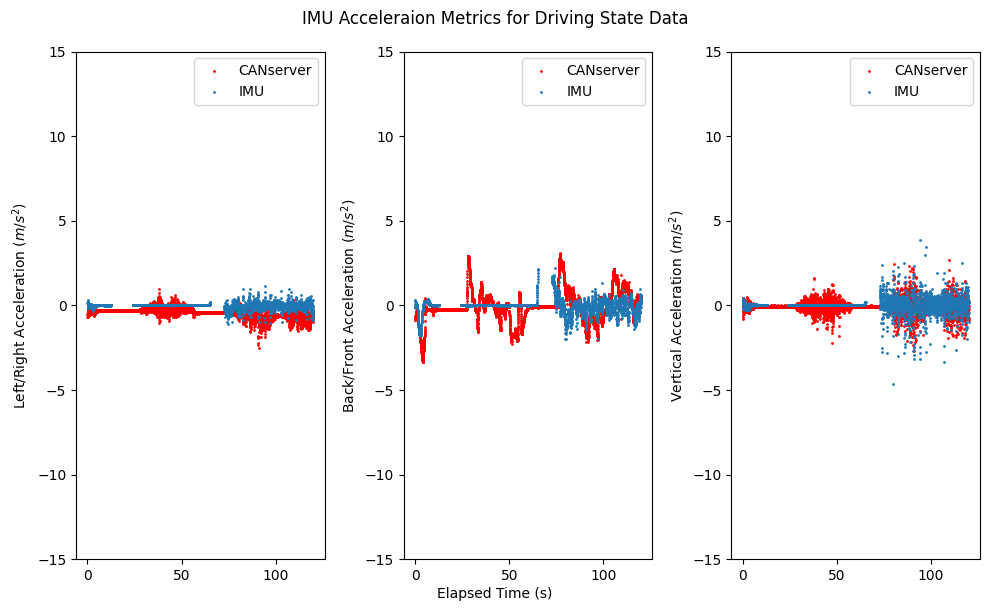

34
1687986935.2413712
1687987205.014904
1687987205.0386574
269.77353286743164


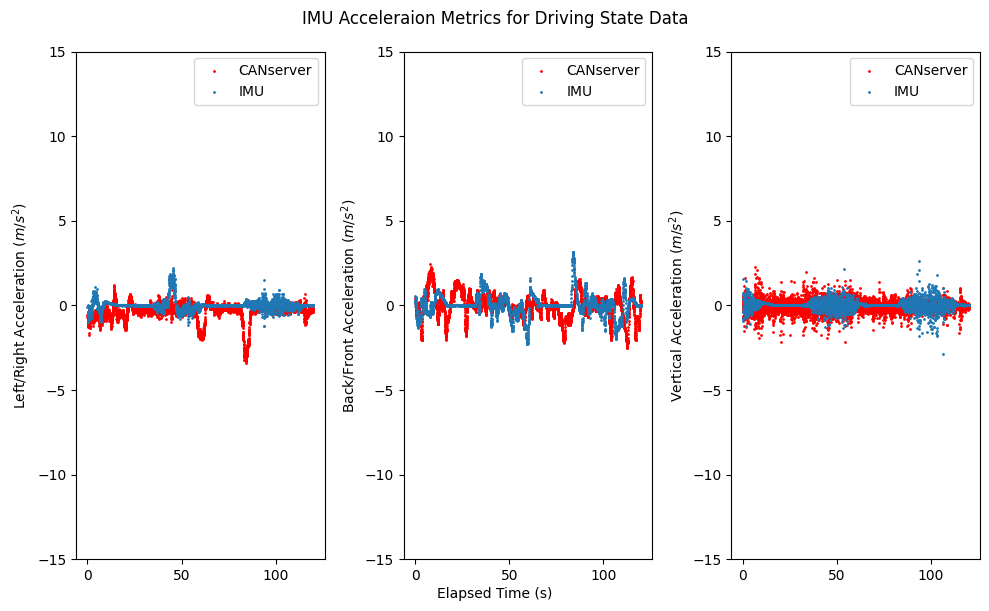

35
1687987055.0318995
1687987325.027466
1687987325.0426133
269.9955666065216


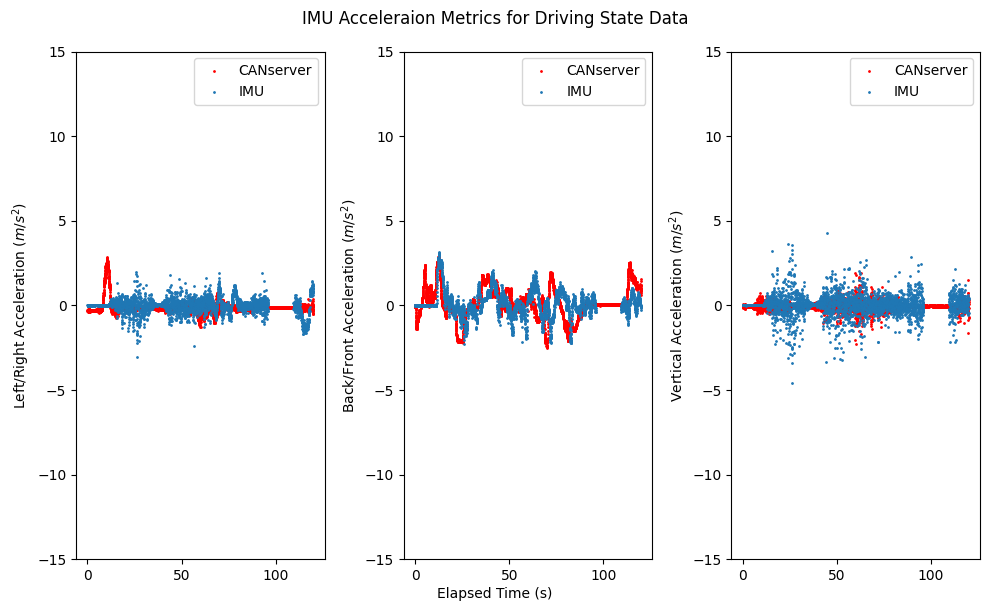

36
1687987174.7889194
1687987445.020883
1687987445.0130014
270.23196363449097


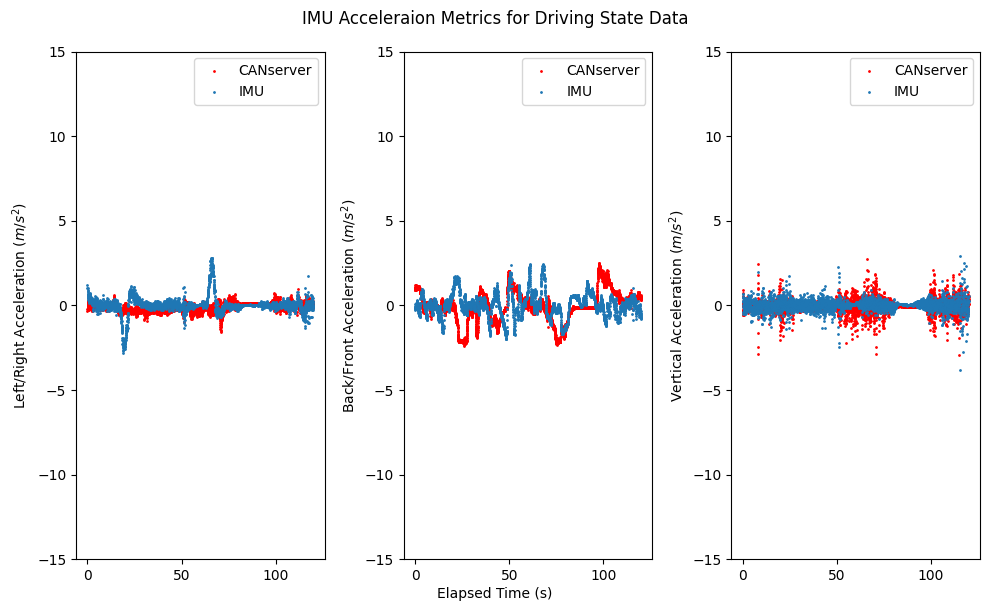

37
1687987294.5794475
1687987565.015967
1687987565.016957
270.43651938438416


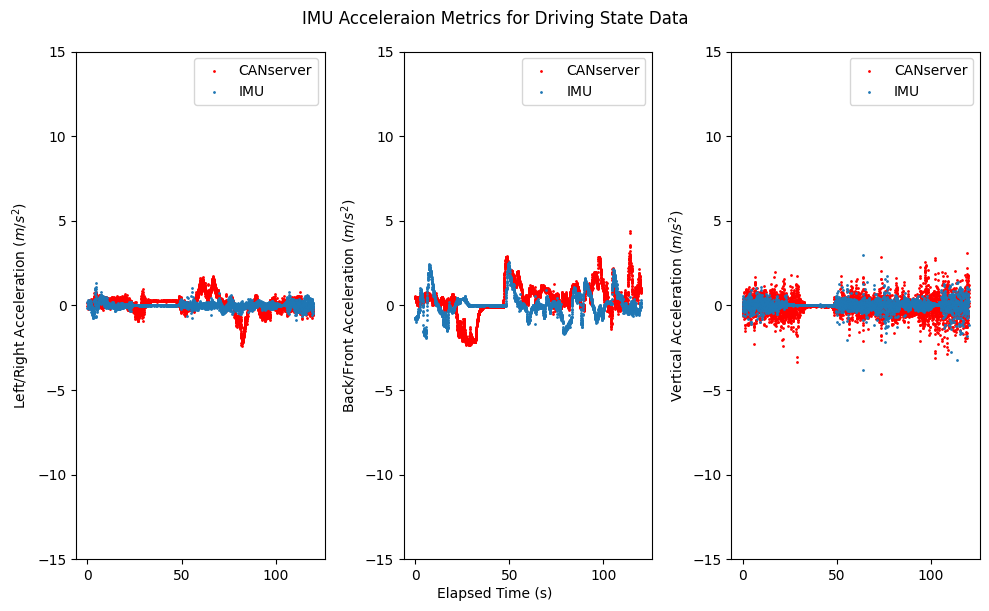

38
1687987414.3699756
1687987685.028155
1687987685.020913
270.65817952156067


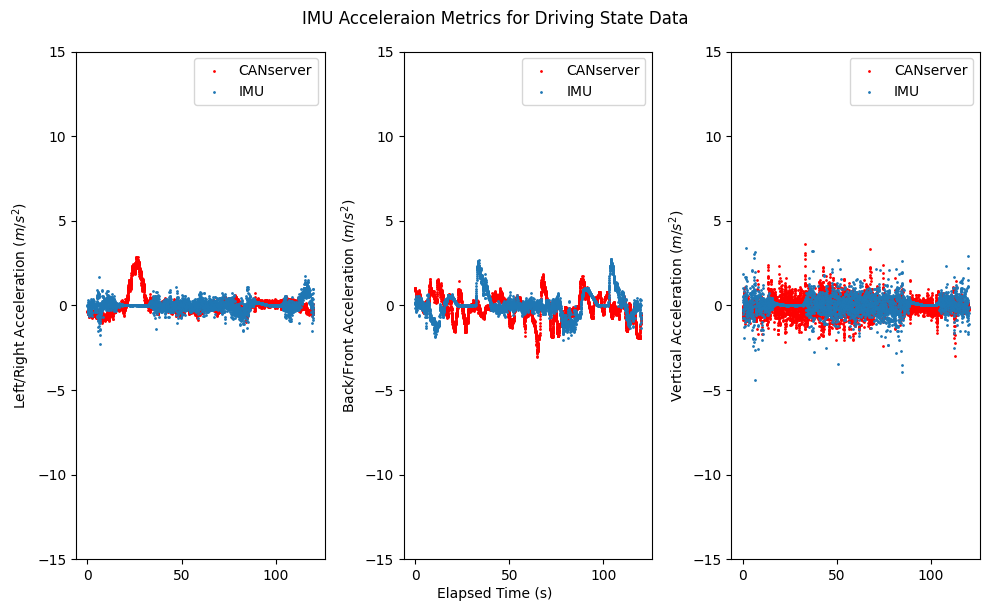

39
1687987534.1605036
1687987805.021894
1687987805.0248687
270.86139035224915


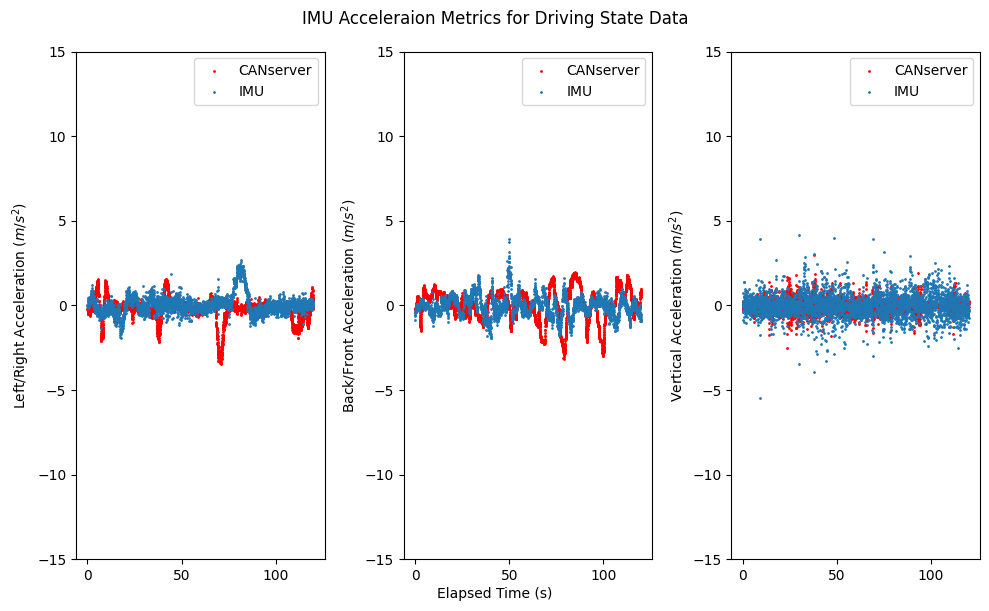

40
1687987653.9510314
1687987925.016242
1687987925.028824
271.0652105808258


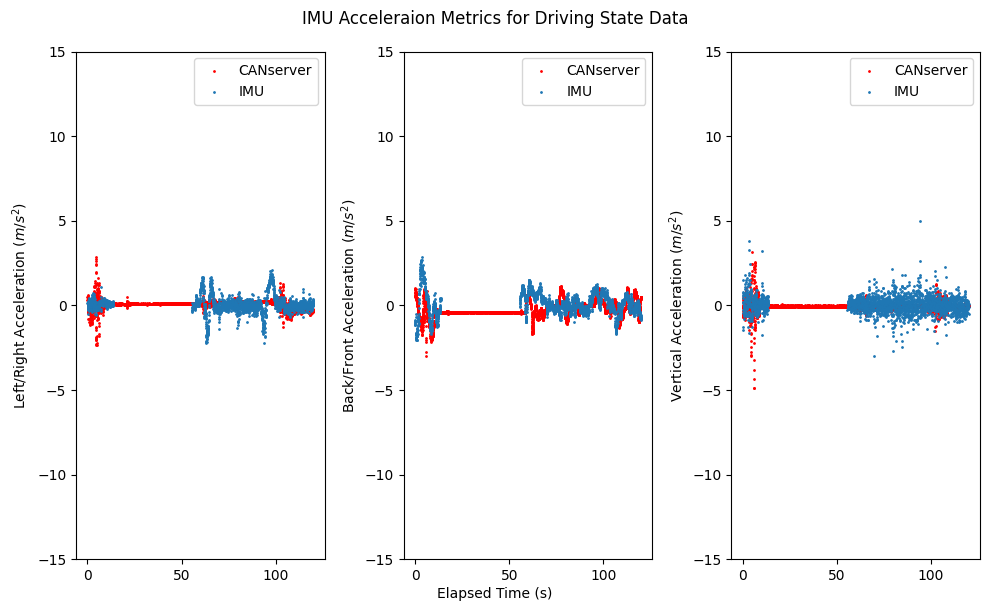

41
1687987773.7415595
1687988045.030483
1687988045.03278
271.2889235019684


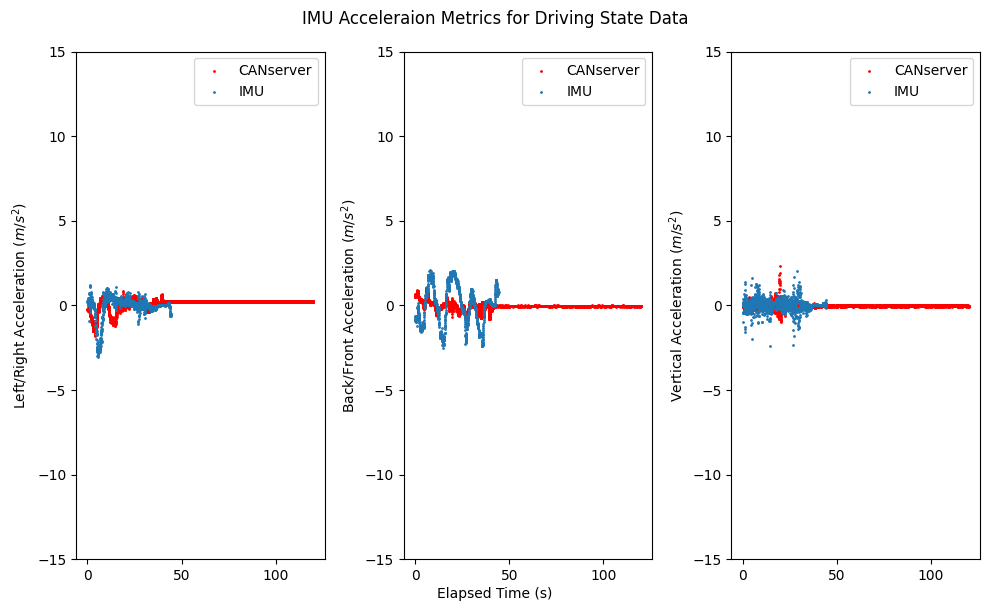

48
1687988711.9945874
1687988885.024355
1687988984.957469
173.02976751327515


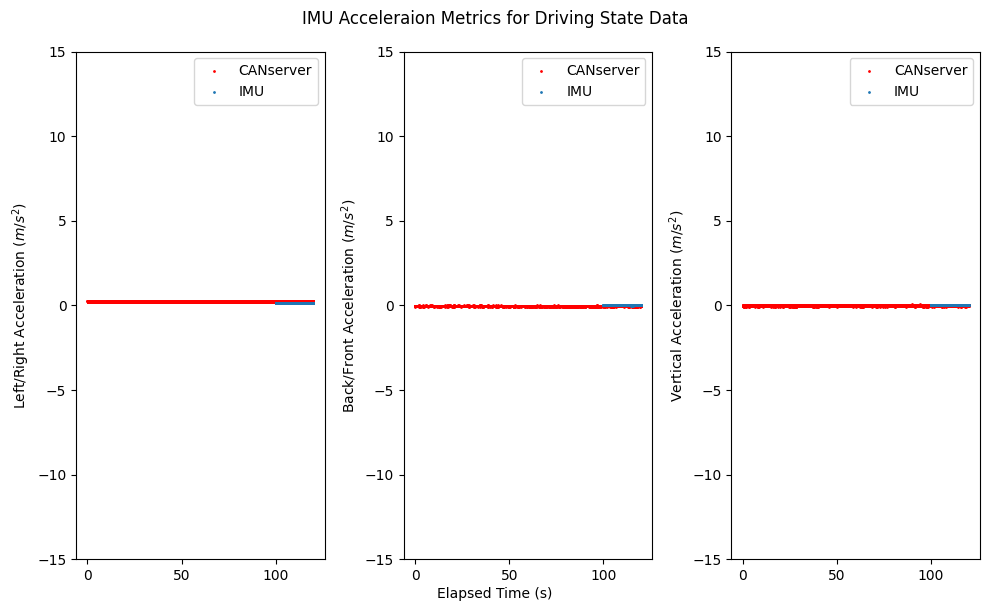

In [27]:
window = 120
count = 0
can_df = can_df[can_df['bf_acc'].notna()]
can_df.reset_index(drop=True, inplace=True)

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        dr_motion = dr_df[(dr_df['correct_timestamp'] >= dr_start_time) 
                        & (dr_df['correct_timestamp'] <= dr_start_time + window)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time) 
                            & (can_df['timestamp'] <= dr_start_time + window)]
        dr_start_time += window

        count += 1
        # if ((len(dr_motion) != 0) and (len(can_motion) != 0) and (count < 20)):
        if ((len(dr_motion) != 0) and (len(can_motion) != 0)):
            print(count)
            print(dr_motion['timestamp(epoch in sec)'].iloc[0])
            print(can_motion['timestamp'].iloc[0])
            print(dr_motion['correct_timestamp'].iloc[0])
            print(can_motion['timestamp'].iloc[0] - dr_motion['timestamp(epoch in sec)'].iloc[0])
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

            fig.set_size_inches(10,6)

            ax1.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=-can_motion['lr_acc'], s=1, color='red', label='CANserver')
            ax1.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['lr_acc(m/s^2)'], s=1, label='IMU')
            ax1.set_ylim(-15,15)

            ax2.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['bf_acc'], s=1, color='red', label='CANserver')
            ax2.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['bf_acc(m/s^2)'], s=1, label='IMU')
            ax2.set_ylim(-15,15)

            ax3.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['vert_acc'], s=1, color='red', label='CANserver')
            ax3.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['vert_acc(m/s^2)'], s=1, label='IMU')
            ax3.set_ylim(-15,15)

            fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
            fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

            ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
            ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
            ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

            ax1.legend()
            ax2.legend()
            ax3.legend()
            plt.tight_layout()
            plt.show()

22


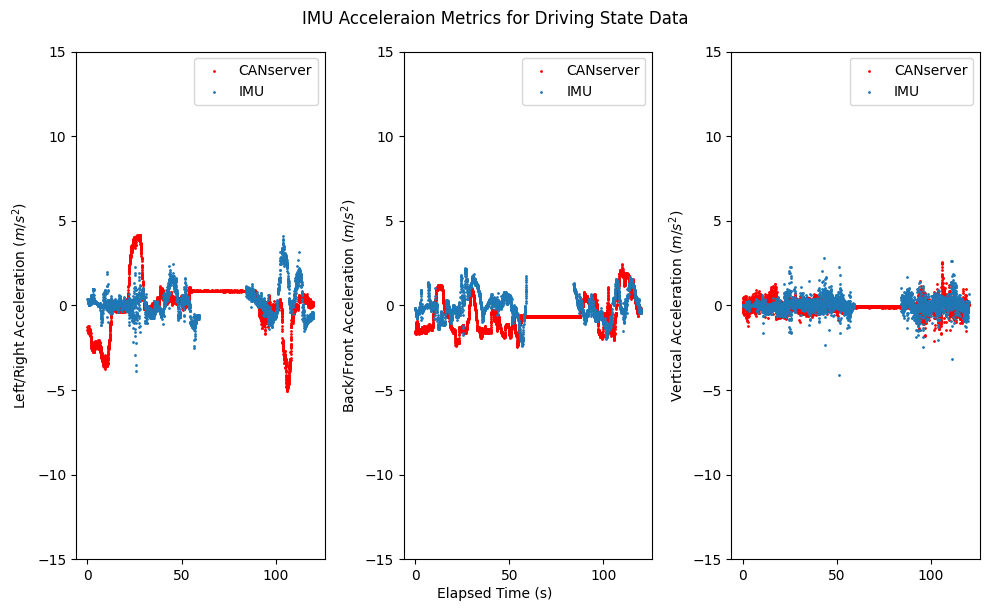

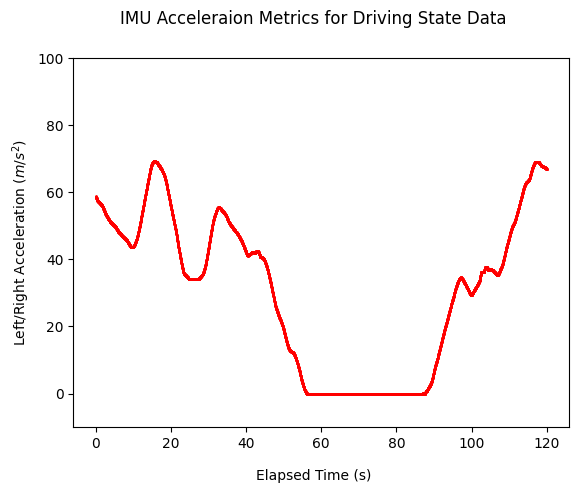

23


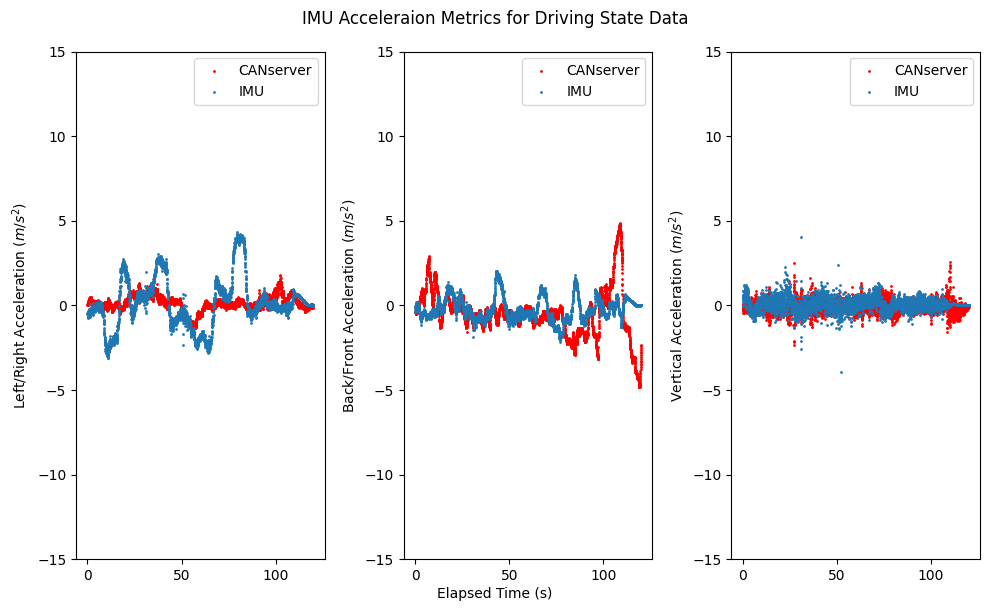

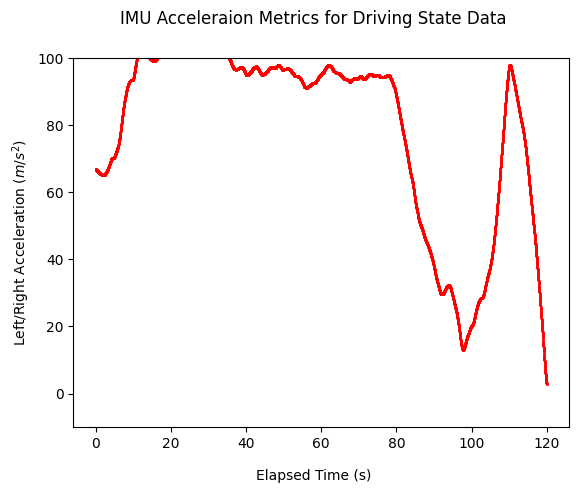

24


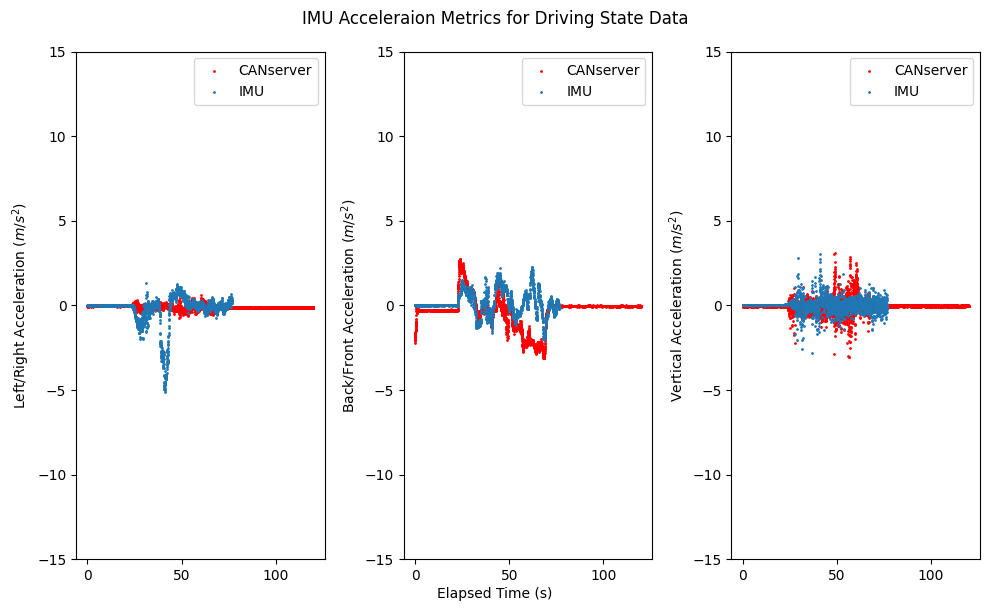

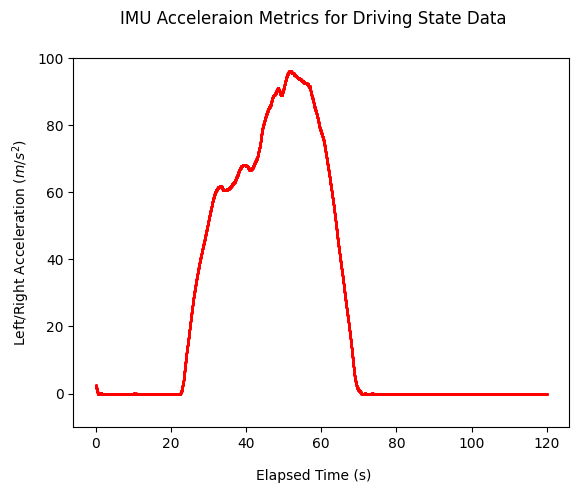

25


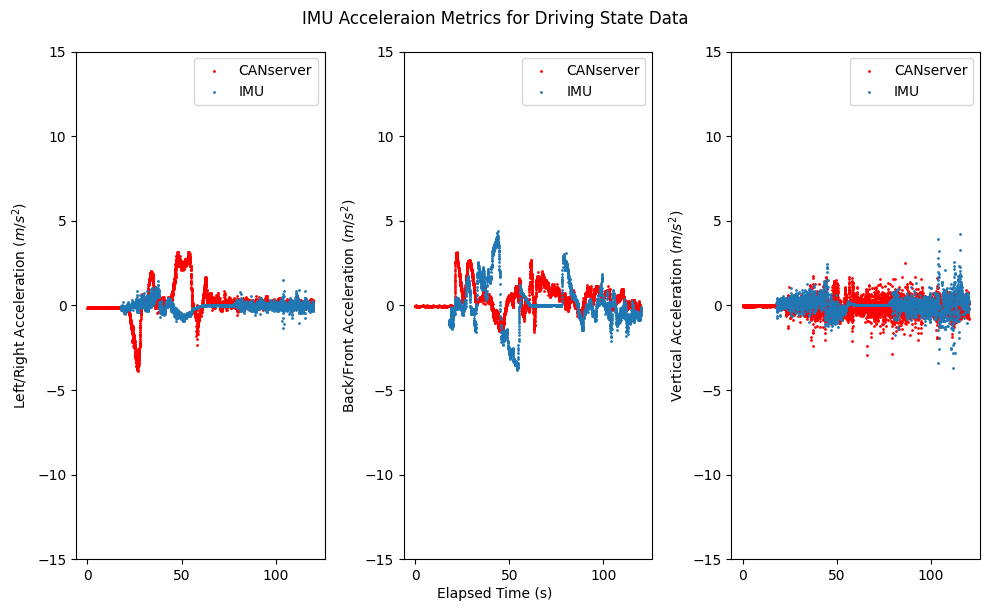

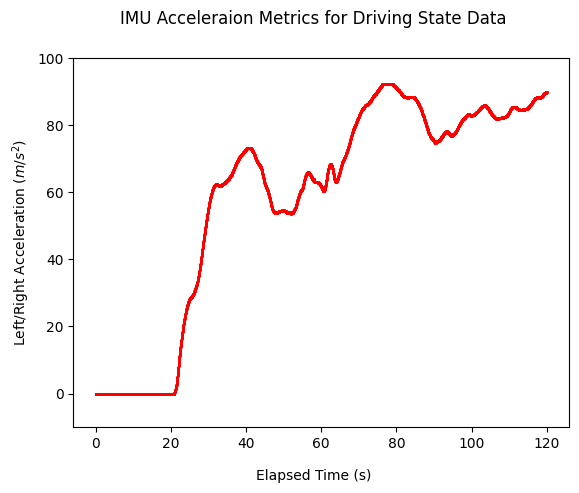

26


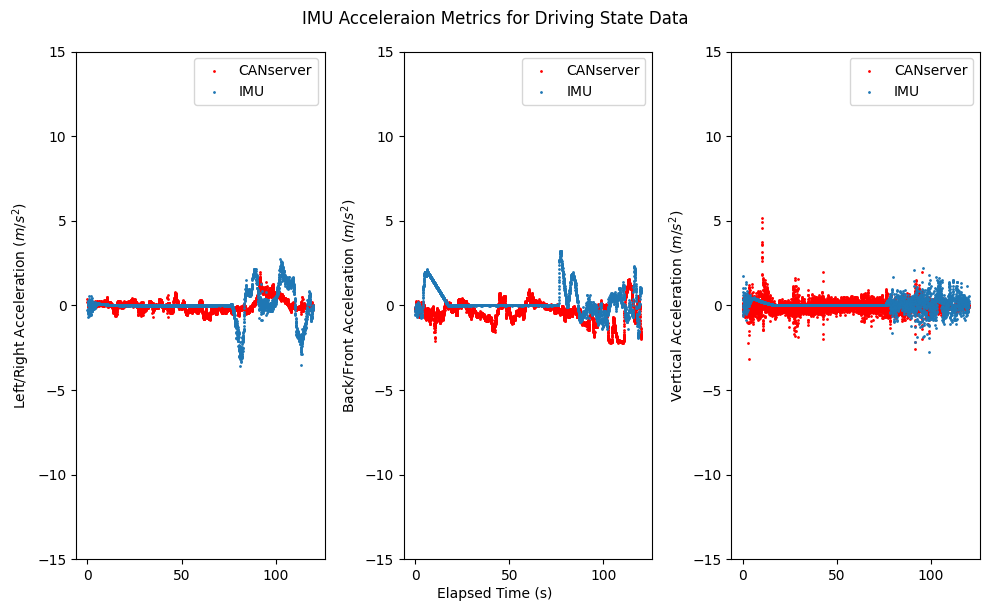

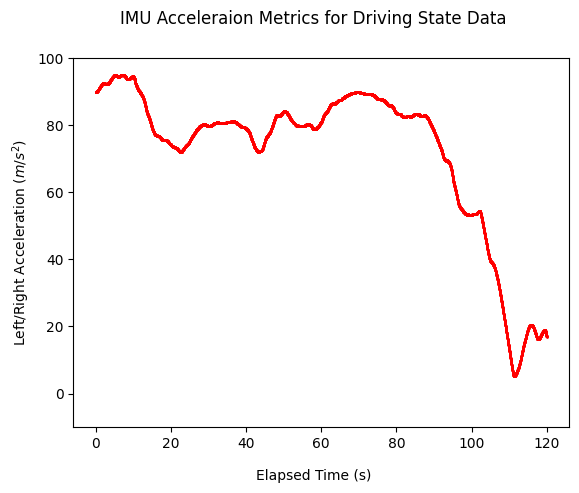

27


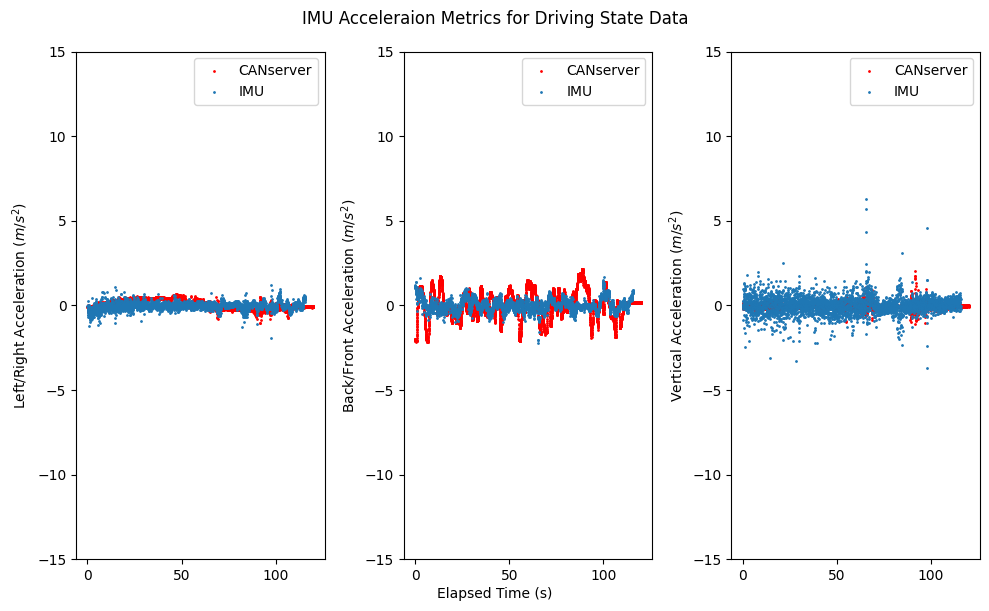

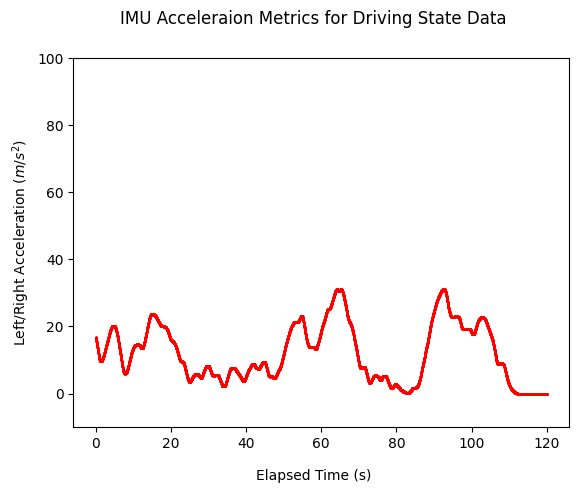

28


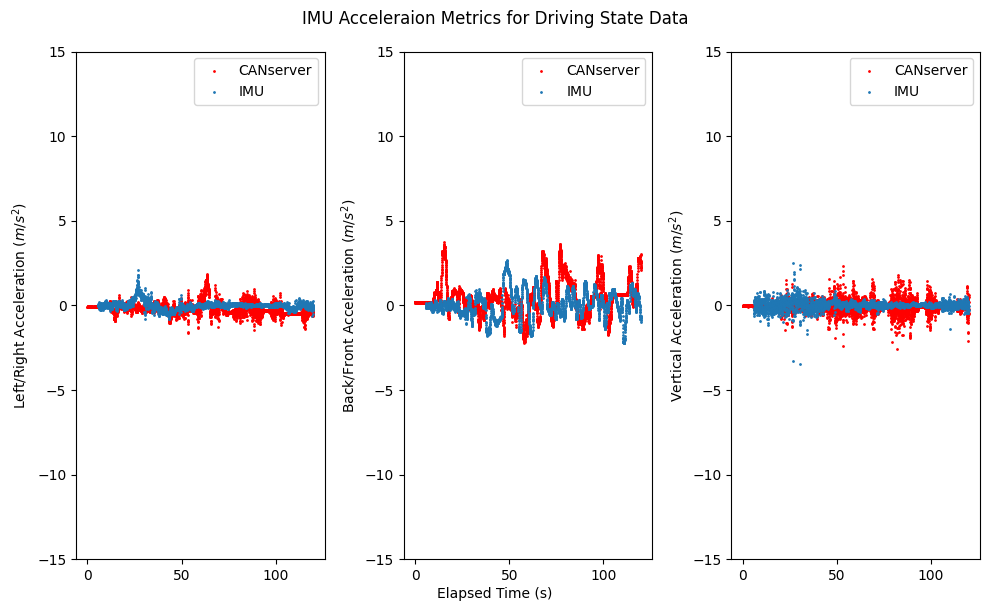

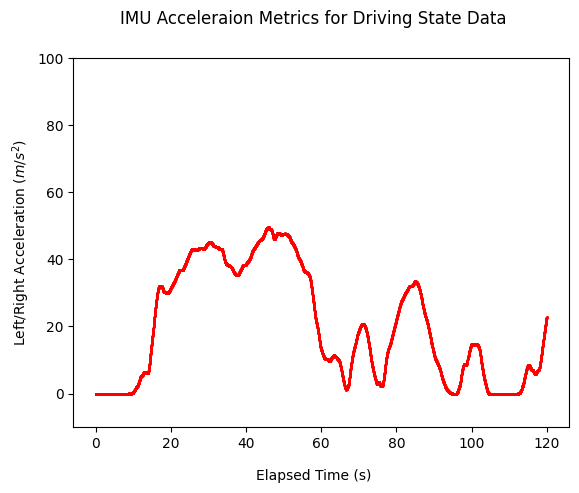

29


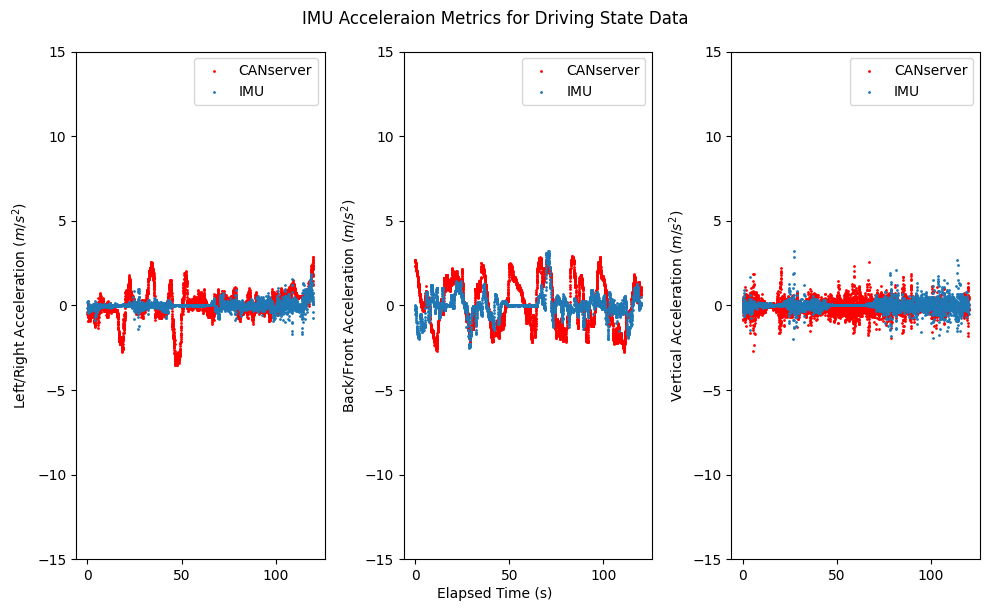

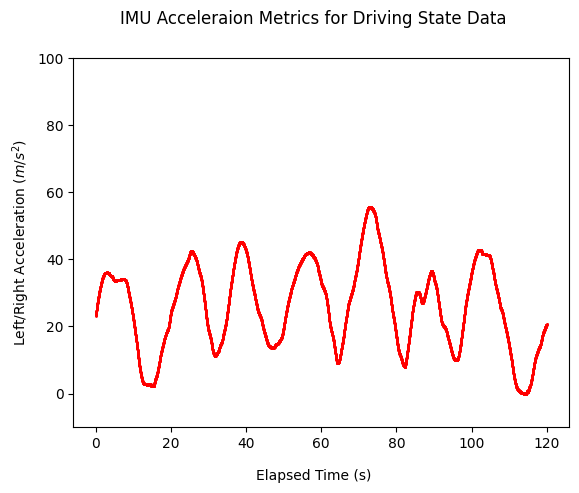

30


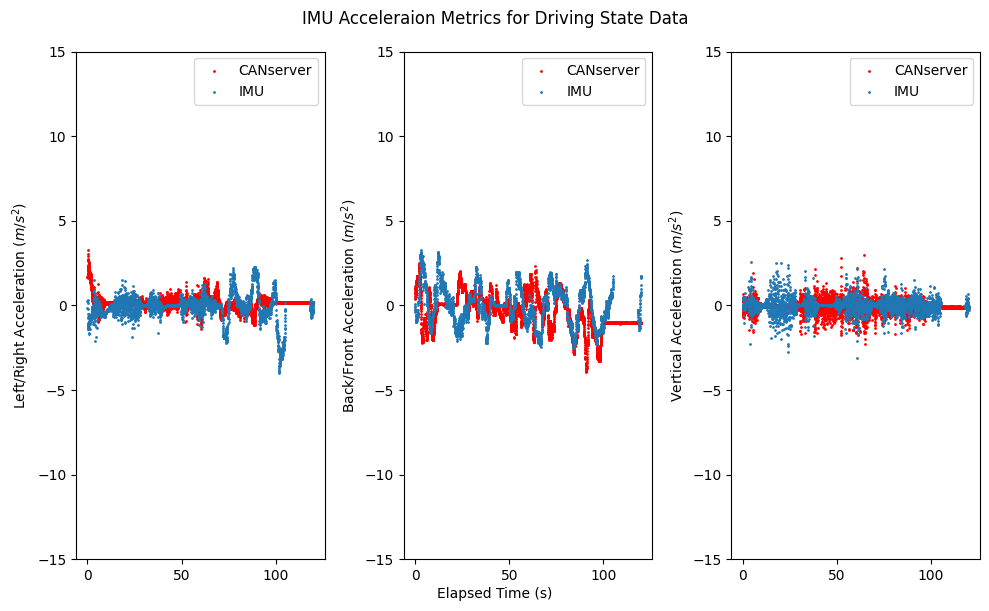

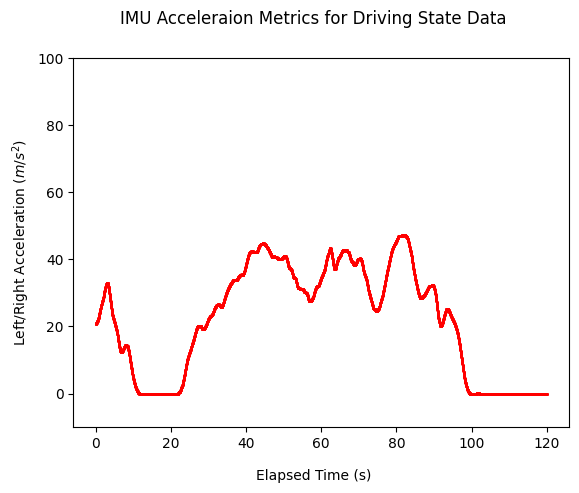

31


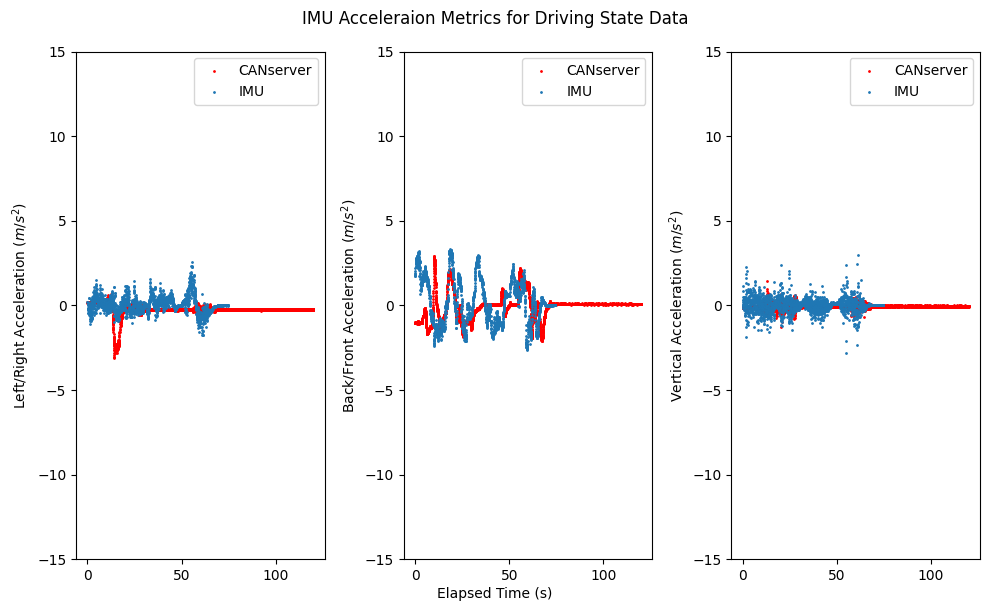

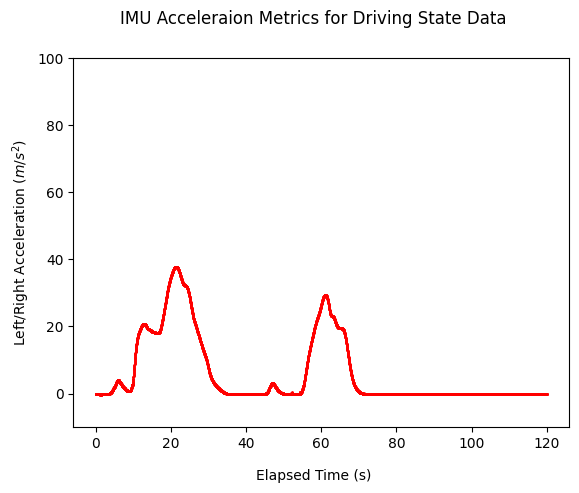

32


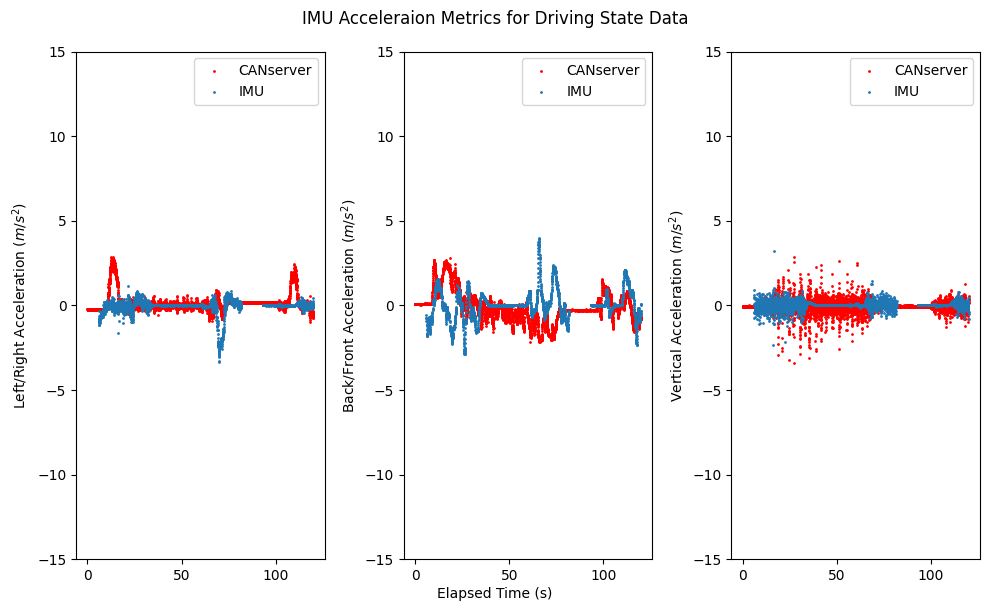

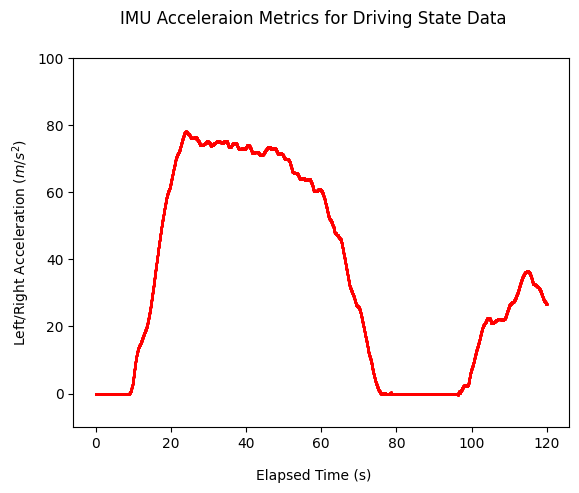

33


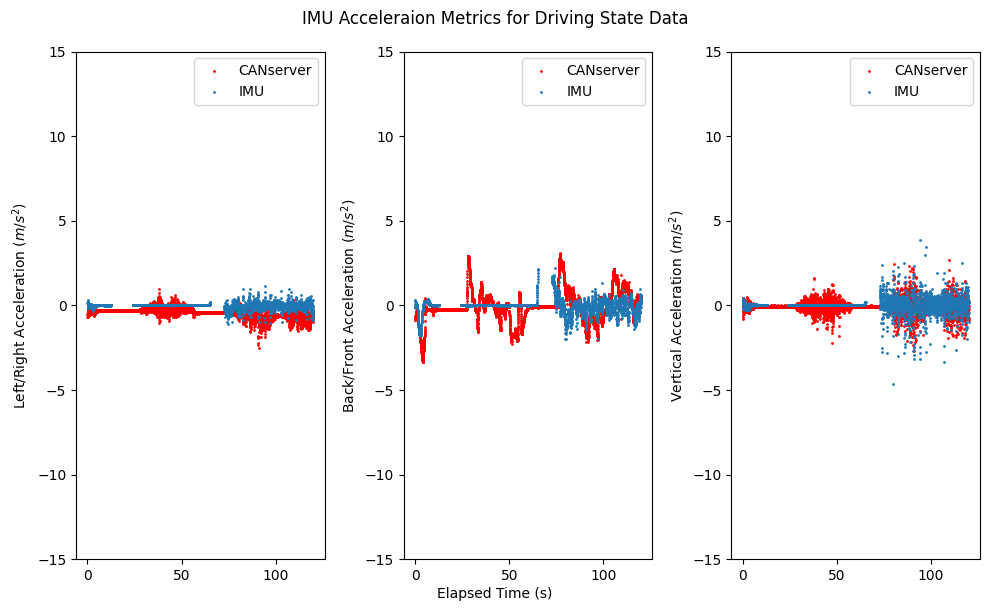

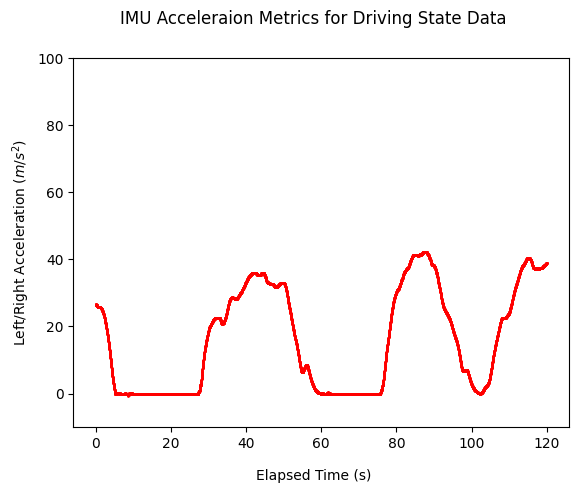

34


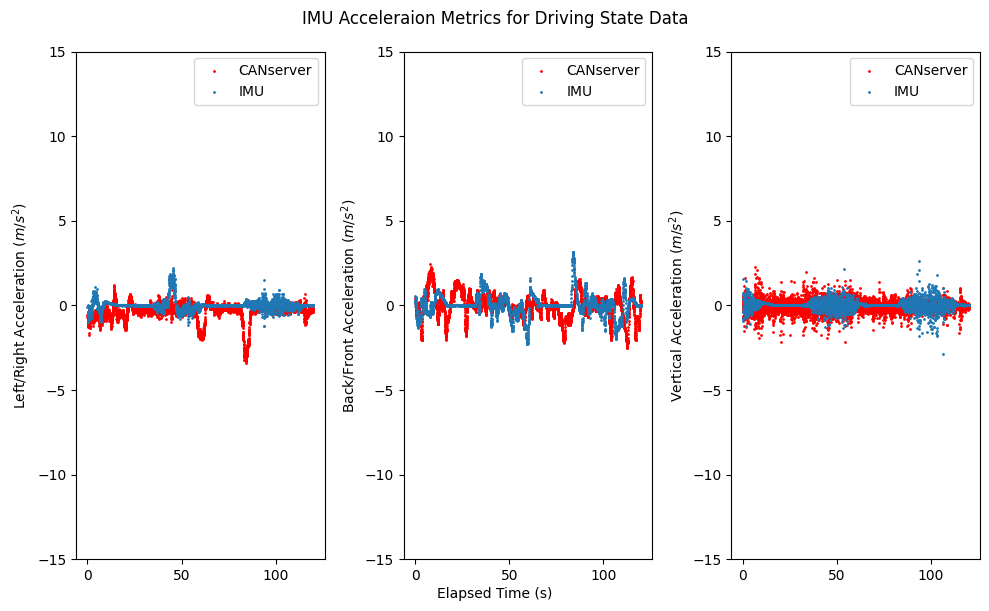

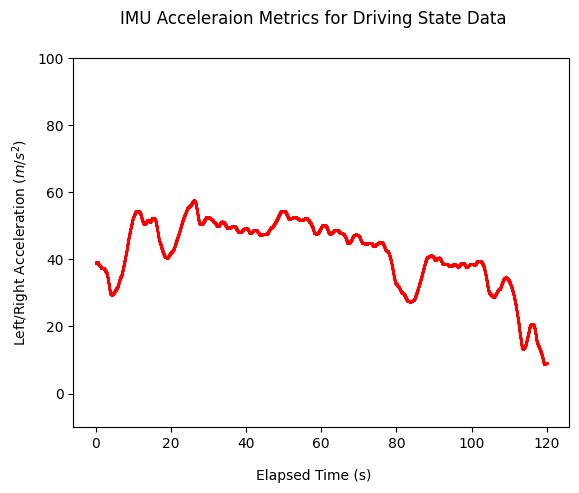

35


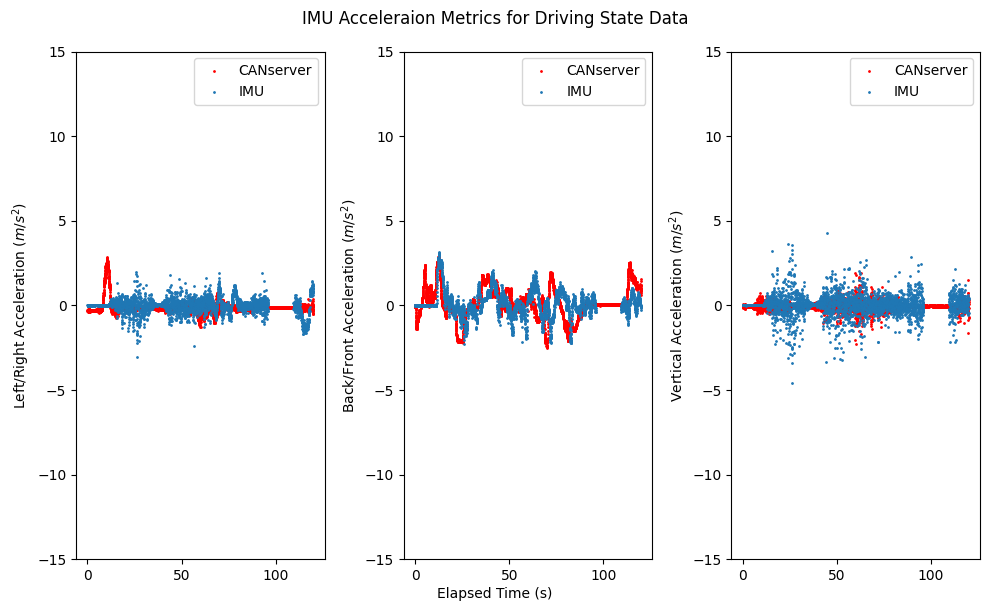

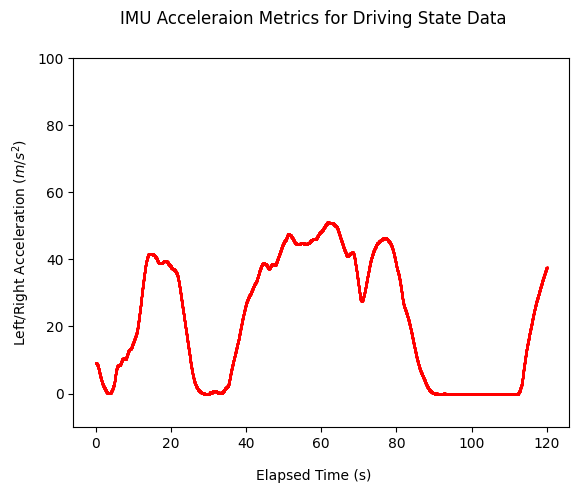

36


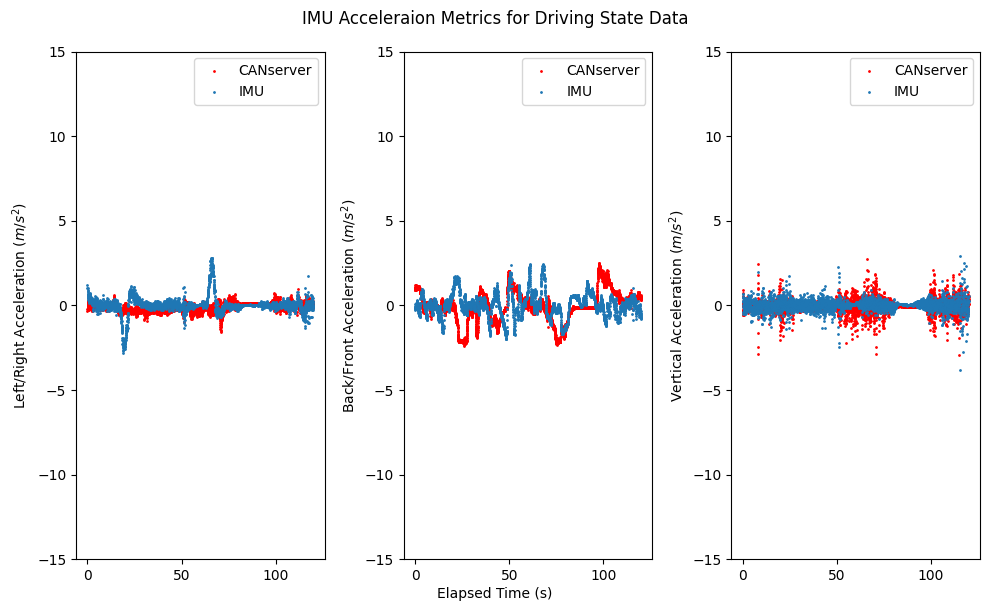

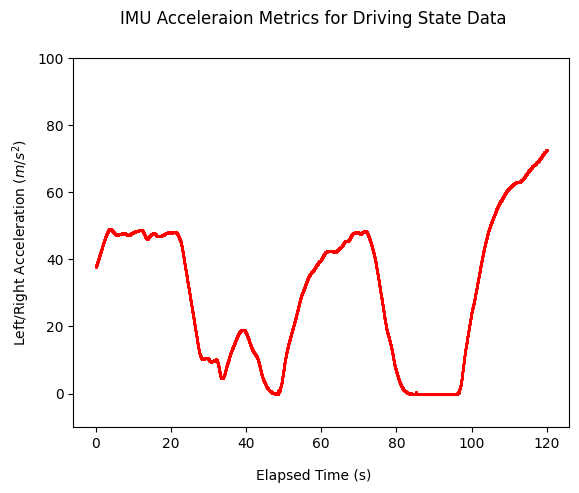

37


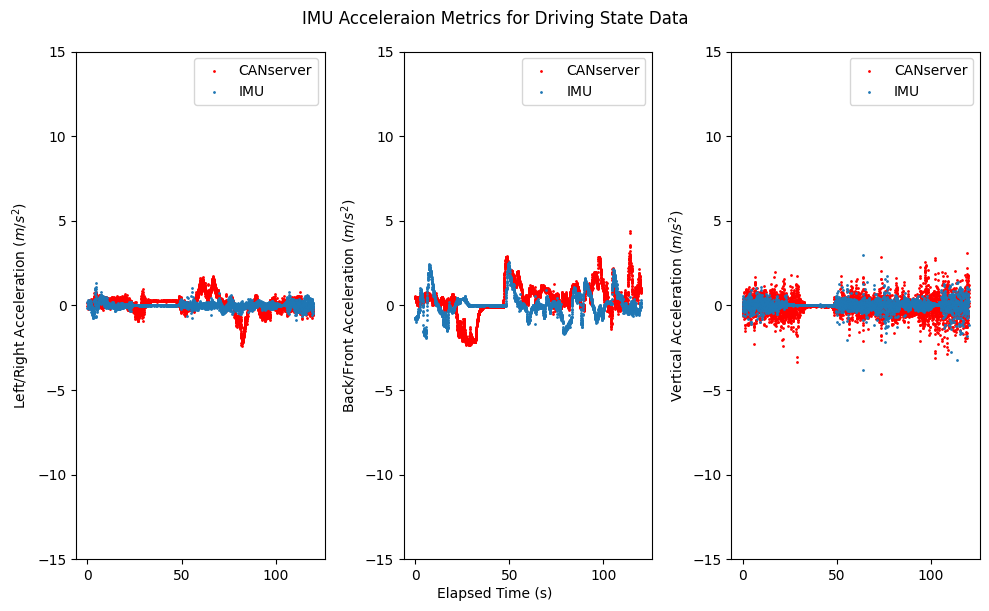

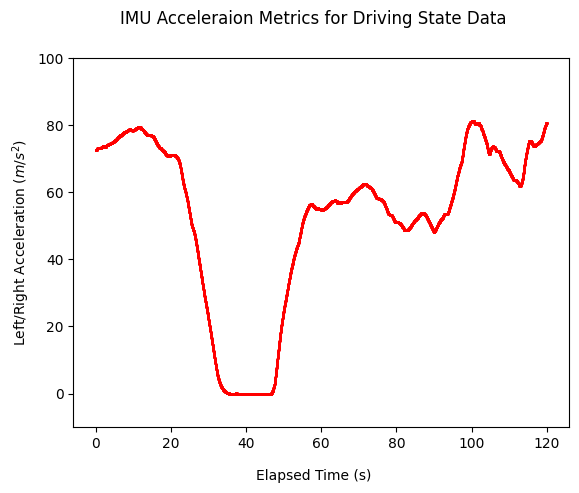

38


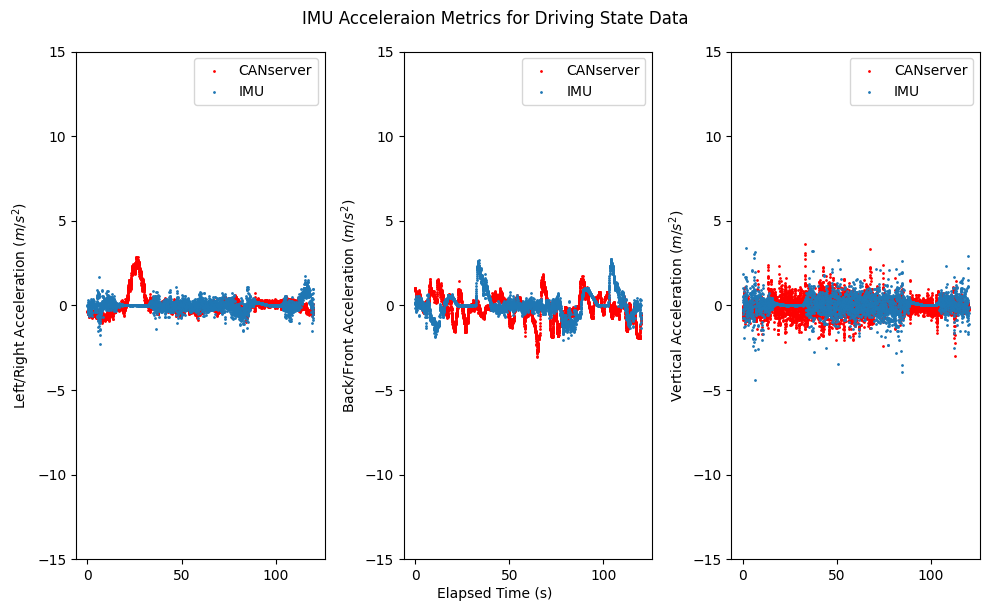

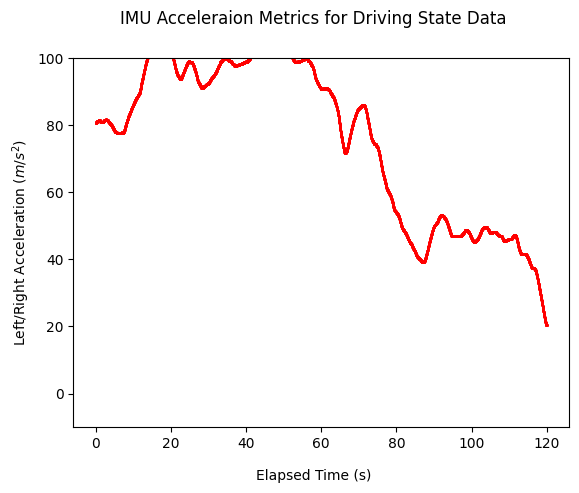

39


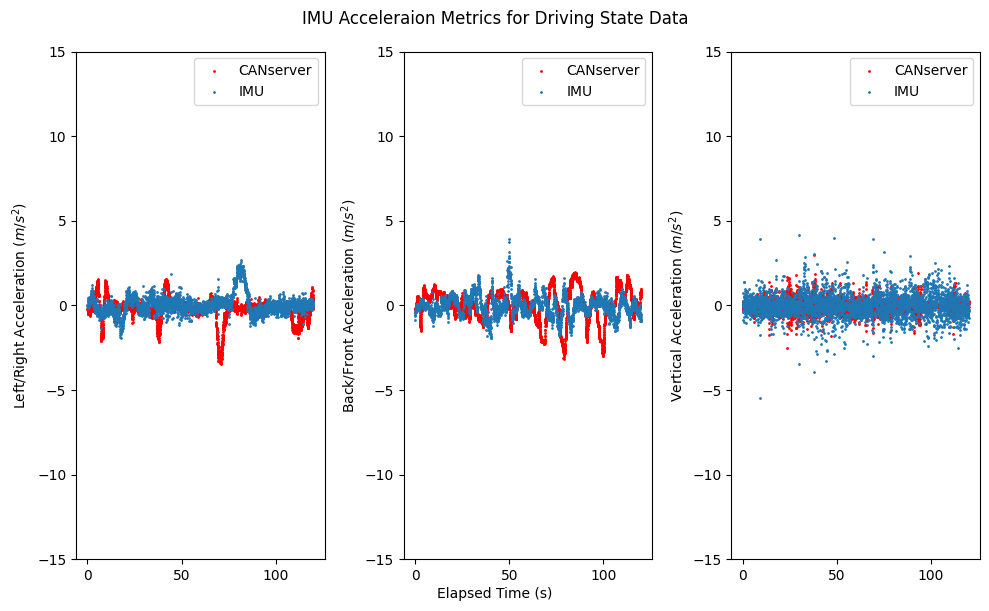

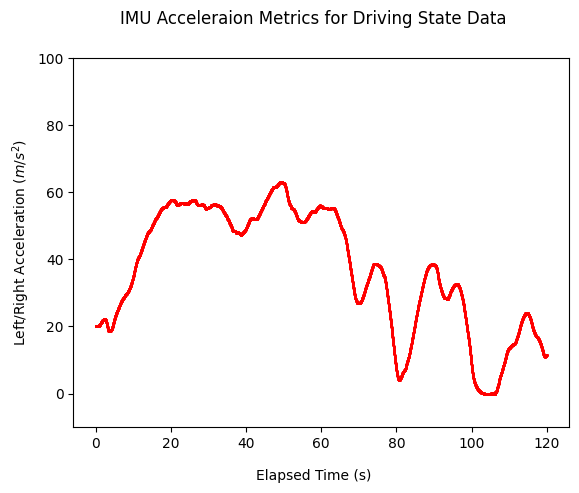

40


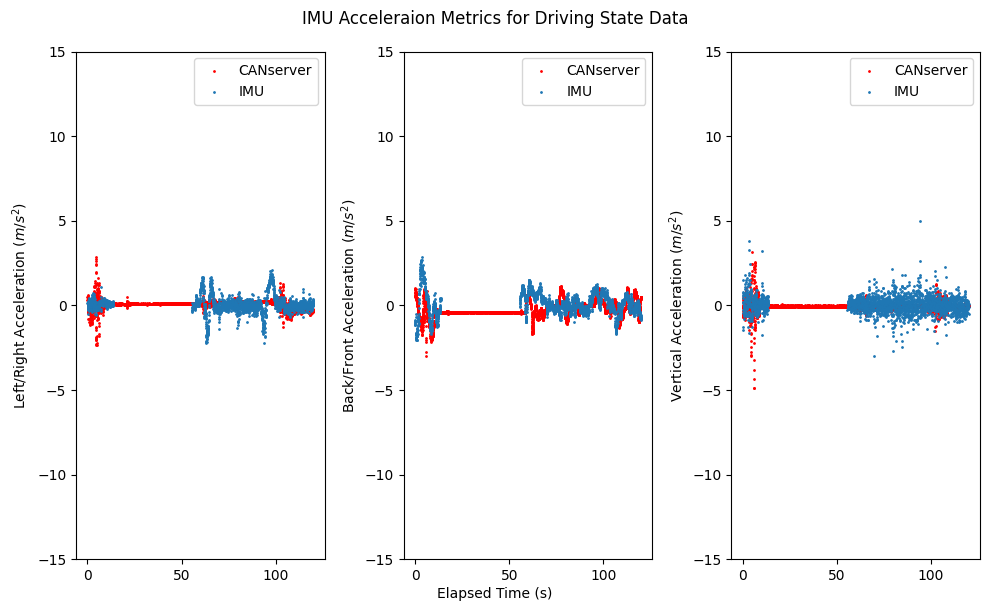

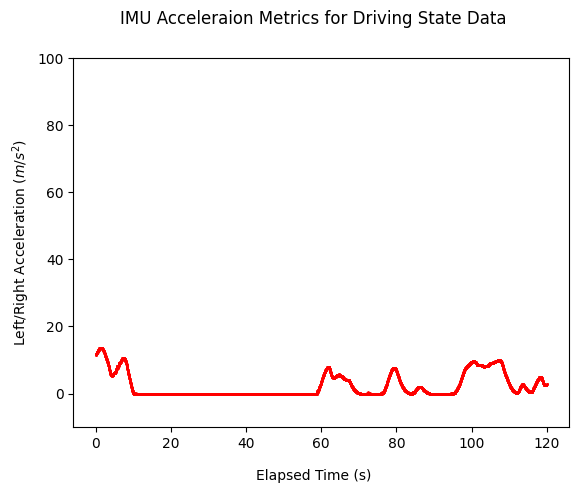

41


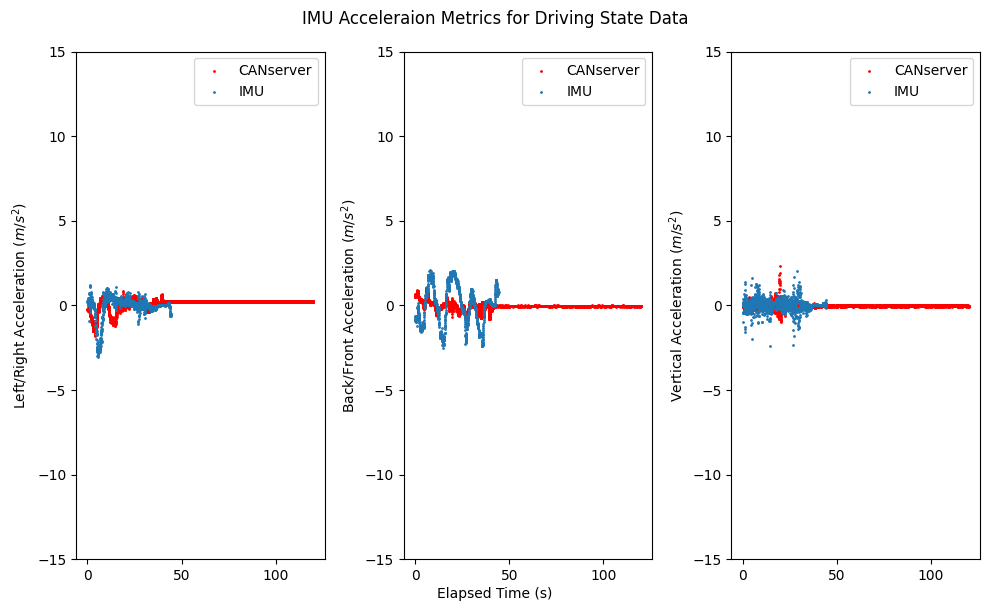

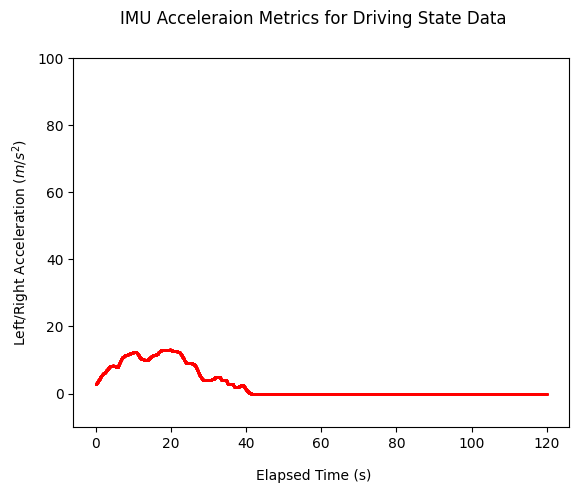

48


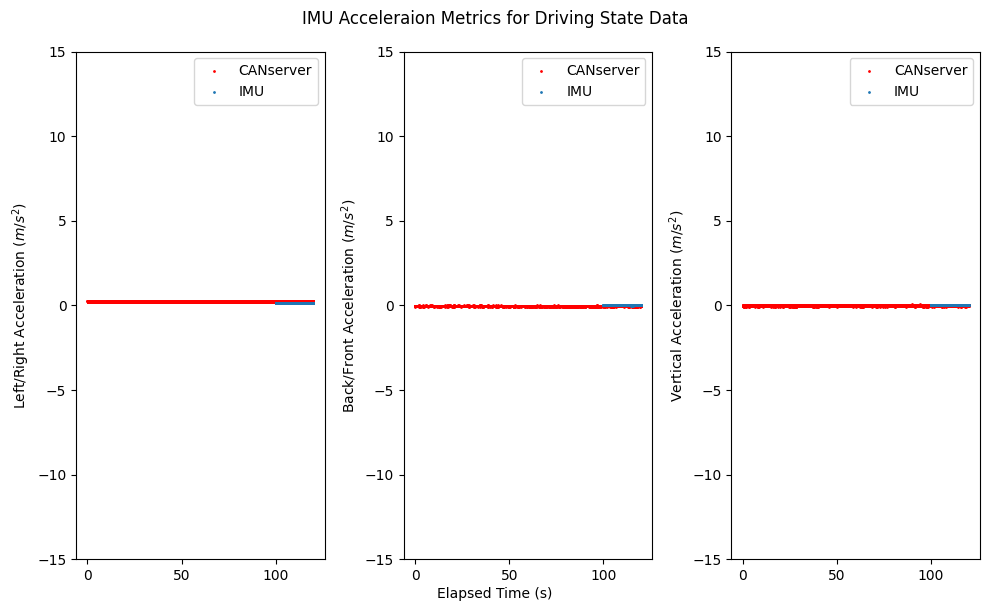

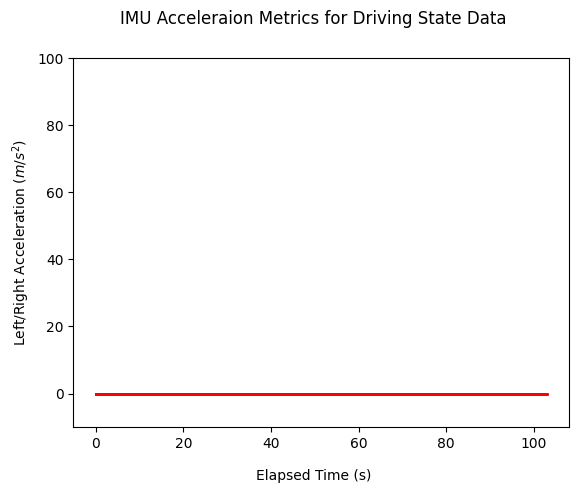

In [24]:
# Check the speed of the car

window = 120
count = 0

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        dr_motion = dr_df[(dr_df['correct_timestamp'] >= dr_start_time) 
                        & (dr_df['correct_timestamp'] <= dr_start_time + window)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time) 
                            & (can_df['timestamp'] <= dr_start_time + window)]
        dr_start_time += window

        count += 1
        # if ((len(dr_motion) != 0) and (len(can_motion) != 0) and (count < 20)):
        if ((len(dr_motion) != 0) and (len(can_motion) != 0)):
            print(count)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

            fig.set_size_inches(10,6)

            ax1.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=-can_motion['lr_acc'], s=1, color='red', label='CANserver')
            ax1.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['lr_acc(m/s^2)'], s=1, label='IMU')
            ax1.set_ylim(-15,15)

            ax2.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['bf_acc'], s=1, color='red', label='CANserver')
            ax2.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['bf_acc(m/s^2)'], s=1, label='IMU')
            ax2.set_ylim(-15,15)

            ax3.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['vert_acc'], s=1, color='red', label='CANserver')
            ax3.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['vert_acc(m/s^2)'], s=1, label='IMU')
            ax3.set_ylim(-15,15)

            fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
            fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

            ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
            ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
            ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

            ax1.legend()
            ax2.legend()
            ax3.legend()
            plt.tight_layout()
            plt.show()



            fig, ax = plt.subplots()

            ax.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['speed'], s=1, color='red', label='CANserver')
            ax.set_ylim(-10,100)

            fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
            fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

            ax.set_ylabel("Left/Right Acceleration ($m/s^2$)")

            plt.show()